# Regimes Validity Analysis via PNL

Lini Zhang, Xiao Guan


# Objectives

1. Trade with mean reversion strategies in periods identified as mean reversion regime to check the validity of the identification and whether we are making money. 
2. Trade with momentum strategies in periods identified as momentum regime to check the validity of the identification and whether we are making money using momentum strategies. 
3. Two regimes and two identified states, calculate Sharpe ratio corresponding to each combination.
4. Use time series model to predict regimes (not done yet)


# Part I Momentum
3. Trade momentum strategies in periods identified as momentum regime. No trade happening in mean-reversion regime.
4. Do PnL analysis to check if we are making profit or loss in the momentum trading periods.




In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fmt
import quandl
import utils as utl
import sympy as sp
sp.init_printing(use_latex = True)
from IPython.display import display
plt.style.use("ggplot")

import datetime
import time
import statsmodels.tsa.stattools as ts
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statistics as stat
from __future__ import division # floating point division in Py2x


Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ETF_symbols = [
                           'XLY',  # XLY Consumer Discrectionary SPDR Fund   
                           'XLF',  # XLF Financial SPDR Fund  
                           'XLK',  # XLK Technology SPDR Fund  
                           'XLE',  # XLE Energy SPDR Fund  
                           'XLV',  # XLV Health Care SPRD Fund  
                           'XLI',  # XLI Industrial SPDR Fund  
                           'XLP',  # XLP Consumer Staples SPDR Fund   
                           'XLB',  # XLB Materials SPDR Fund  
                           'XLU'  # XLU Utilitiy SPDR Fund
                           #'XLRE'     # XLRE real-estate
            ]

In [3]:
# Read data
main_dir = "C:/Users/dell/Documents/Python Scripts/Capstone Project/program development"
sub_dir = "/data"
ETF_data = utl.data_preprocessing(main_dir, ETF_symbols, sub_dir)

In [4]:
# obtain the adjusted close price from ETF dictionary formed data
ETF_adjclose = utl.obtain_adjusted_close(ETF_data)

# create the pandas dataframe for the adjusted close prices       

tt = 252*7-200
#tt = 252*12-10
ETF_close = ETF_adjclose.iloc[tt:,:]



In [5]:
#use the first 10 month as initial dataset for estimation
t0 = 215 #10 month
data = ETF_close.iloc[0:t0,:]
sector_mean = data.mean(axis = 0)
data_mo = data

# use past 1 month data to estimate returns for mean reversion strategy 
n = len(data_mo)
data_mr = data.iloc[n-21:,:] 


In [6]:
# data should not include future prices
def return_sort(data, tnum, bnum):
    # total number of trading days
    T = len(data)
    # total number of stocks
    n = len(data.transpose()) 
    #number of years
    y = T/252.0  
    ret = []
    #annualized return 
    for i in range(n):
        r = (data.iloc[0,i]-data.iloc[T-1,i])/data.iloc[T-1,i]
        r = (1.0+ r)**(1./y) -1.
        ret.append(r) 
    # sort returns in ascending order     
    ret_index = sorted(range(len(ret)),key=lambda x:ret[x]) 
    # select bottom three & top three returns
    stocks=[]
    stocks.append(ret_index[0:bnum])
    stocks.append(ret_index[n-tnum: n])
    #print('ret_index = ', ret_index, ' ret = ', ret)
    return stocks
    

def mean_revert_position(wealth, pl, ph):
     
    # calculate shares position with mean reversion strategy
    # pl is prices of bottom stocks
    # ph is prices of top stocks
    # long bottom return stocks
    # short top return stocks
    # p1 is the shares position in shorted bottom stocks
    # p2 is the shares postion in longed top stocks
    
    w = 2.0*wealth/len(pl)   
    wealth_list = [w] * len(pl)
    p1 = list_divide(wealth_list, pl)
    
    w = -wealth/len(ph)
    wealth_list = [w] * len(ph)
    #print(wealth_list)
    p2 = list_divide(wealth_list, ph)    
    position = [p1, p2]
 
    return position


def momentum_position(pl, ph, wealth):
    
    # calculate shares position using momentum strategy
    # pl is prices of bottom stocks
    # ph is prices of top stocks
    # long top return stocks
    # short bottom return stocks
    # assign equal weights of wealth to each stock
    # p1 is the shares position in shorted bottom stocks
    # p2 is the shares postion in longed top stocks
    
    w = -wealth/len(pl) 
    wealth_list = [w] * len(pl)
    p1 = list_divide(wealth_list, pl)
    
    w = 2.0*wealth/len(ph)
    wealth_list = [w] * len(ph)
    p2 = list_divide(wealth_list, ph)
    position = [p1, p2]    
    return position


def mean_reversion_build(t, stocks, prices, position, data_mr, tnum, bnum):
    # build new mean_reversion portfolio
    # given stocks held last period
    # first close position
    # next select new stocks and build new position
    pl, ph = ppair(t, stocks, prices)    
    wealth = close(position, pl, ph)

    stocks = return_sort(data_mr, tnum, bnum)
    pl, ph = ppair(t, stocks, prices)
    pos = mean_revert_position(wealth, pl, ph)
    return pos, wealth, stocks


def momentum_build(t, stocks, prices, position, data_mo, tnum, bnum):
    # build new momentum portfolio
    # given stocks held last period
    # first close position
    # next select new stocks and build new position
    pl, ph = ppair(t, stocks, prices)
    wealth = close(position, pl, ph)

    stocks = return_sort(data_mo, tnum, bnum)
    pl, ph = ppair(t, stocks, prices)
    pos = momentum_position(pl, ph, wealth)
    #if (t == 21):
    #    print('t = ', t, 'count = ', count, 'wealth = ', wealth, 'stocks = ', stocks, ' pl = ', pl, ' ph =', ph)
    #    fmt.display(data_mo)
    
    return pos, wealth, stocks


def close(position, pl, ph):
    # close position when switch regime 
    # sum up portfolio values in short/long positions
    # end_t is one period head    
    wealth = list_inner_product(position[-1][0], pl) + list_inner_product(position[-1][1], ph)
    return wealth


def wealth_cal(pos, stocks, time, prices):
    # sum up portfolio values in short/long positions
    # the difference in the definitions of wealth_cal and close is the timing of position 
    pl, ph = ppair(time, stocks, prices)
    wealth = list_inner_product(pos[0], pl) + list_inner_product(pos[1], ph)
    return wealth


def ppair(t, pairs, prices):
    pl=[]
    for i in range(len(pairs[0])):
        pl.append(prices.iloc[t][pairs[0][i]])
    ph=[]
    for j in range(len(pairs[1])):
        ph.append(prices.iloc[t][pairs[1][j]])
    return pl, ph

  
    
def list_divide(a, b):
    # a and b are two lists
    # a = [1, 2, 3]
    # b = [2, 8, 9]
    # return [0.5, 0.25, 0.333]
    return [x/y for x, y in zip(a, b)]



def list_inner_product(a, b):
    # a and b are two lists
    # a = [1, 2, 3]
    # b = [0, 1, 4]
    # return 0+ 2+ 12 = 14
    return sum([x*y for x,y in zip(a, b)])


In [7]:
#daily return, monthly return, cumulative return
def return_cal(wealth_path):
    cum_return =[0]
    daily_return = [0]
    periods = len(wealth_path)
    for t in range(1,periods):
        c_r = (wealth_path[t] - wealth_path[0])/wealth_path[0]
        d_r = (wealth_path[t] - wealth_path[t-1])/wealth_path[t-1]
        cum_return.append(c_r)
        daily_return.append(d_r)    
    
    mon_return =[]# monthly return
    mnum = int(periods/21)+1
    for t in range(mnum):
        d1 = t*21
        d2 = (t+1)*21 
        if (d2 >= periods):        
            m_r = (wealth_path[periods-1] - wealth_path[d1])/wealth_path[d1]
        else:
            m_r = (wealth_path[d2-1] - wealth_path[d1])/wealth_path[d1]
        mon_return.append(m_r)
    return daily_return, mon_return, cum_return
    

#summary statitsics
def summary_stats(cum_return, daily_return, risk_free):
    #compound annual return
    periods = len(cum_return)
    y = periods/252
    ret = cum_return[periods-1]
    annual_ret = (1.0+ ret)**(1./y) -1.  

    # sharpe ratio
    # daily return volatility
    r_mu = stat.mean(daily_return)
    r_std = stat.stdev(daily_return)
    sharpe_ratio = (r_mu - risk_free)/r_std
    std_annual = r_std*np.sqrt(252.)
    sharpe_annual = (annual_ret - risk_free*252)/std_annual
    return annual_ret, sharpe_ratio, r_std, sharpe_annual


In [8]:
# PnL analysis
# step = 1 is daily PnL
# step = 5 is weekly PnL
# If ending wealth >= begining wealth, then we make a profit

def pnl_cal(df_len, wealth_path, step):
    n = len(wealth_path)
    # initialize lists
    if (df_len == n):        
        pnl = [0]
        indicators = [1]
    else:
        pnl = []
        indicators = []
    
    for i in range(step,n,step):
        pnlc = wealth_path[i] - wealth_path[i-step]
        lpn = [pnlc]*step
        if (pnlc >=0):
            indicator = [1]*step # 1 = profit, when ending wealth >= begining wealth
        else:
            indicator = [0]*step # 0 = loss, ending wealth < begining wealth
        pnl.extend(lpn)
        indicators.extend(indicator)
        
    # adjust the length of lists
    while(len(indicators)> n):
        del indicators[-1]
        del pnl[-1]
        
    if (len(indicators)< n):
        pnlc = wealth_path[n-1] - wealth_path[i]
        lpn = [pnlc]*(n-1-i)
        if (pnlc >=0):
            indicator = [1]*(n-1-i) # 1 = profit
        else:
            indicator = [0]*(n-1-i) # 0 = loss
        pnl.extend(lpn)
        indicators.extend(indicator)            
        
    return pnl, indicators



# Momentum
1. Trade momentum strategies in periods identified as momentum regime. No trade happening in mean-reversion regime.
2. Do PnL analysis to check if we are making profit or loss in the momentum trading.


In [9]:
# trade pure momentum strategy in periods identified as momentum

def pure_momentum(signals, wealth, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates):    
    
    # list initialization 
    position = []  
    stock_track = []
    wealth_path = [] 
    del_row = []
    wealthss = []

    
    prices = ETF_close.iloc[t0:, :]
    regimes = ['momentum', 'no trading']
    periods = len(prices)


    # seartch the first momentum trading period       
    k = 0
    while (signals[k] != 0):
        print('date = ', dates[k], 't = ', k, ' signal = ', signals[k], '  no trading')
        df = ETF_close.iloc[t0+k,:]
        data_mo = data_mo.drop(data_mo.index[0])
        data_mo = data_mo.append(df)
        del_row.append(dates[k])
        k += 1
        
    flag = True
    stocks = return_sort(data_mo, tnum, bnum)
    pl, ph = ppair(k, stocks, prices)
    pos = momentum_position(pl, ph, wealth)
    count_mo = 1
    regime_state = 0

    position.append(pos)
    stock_track.append(stocks)
    wealth_path.append(wealth)
    wealthss.append(wealth)
    df = ETF_close.iloc[t0+k,:]
    data_mo = data_mo.drop(data_mo.index[0])
    data_mo = data_mo.append(df)
    print('date = ', dates[k], 't = ', k,  '  momentum   ', ' wealth = ', wealth_path[-1])

        
    
    for t in range(k+1,prices.shape[0]):
        signal = signals[t]
        if (regime_state == 0 and signal == 0):
            # continous momentum
            if (count_mo % k_mo == 0 ):
                # update portfolio every month
                stocks = stock_track[-1]                
                pos, wealth, stocks = momentum_build(t, stocks, prices, position, data_mo, tnum, bnum)
                
            else:
                pos = position[-1]
                stocks = stock_track[-1]
                wealth = wealth_cal(pos, stocks, t, prices)
            
            count_mo +=1
            flag = True
            position.append(pos)
            wealth_path.append(wealth)
            stock_track.append(stocks) 
             
        
        elif ( regime_state == 1 and signal == 0):
            # new momentum
            wealth = wealth_path[-1]
            stocks = return_sort(data_mo, tnum, bnum)
            pl, ph = ppair(t, stocks, prices)
            pos = momentum_position(pl, ph, wealth)
            regime_state = 0
            count_mo = 1
            flag = True
            position.append(pos)
            stock_track.append(stocks)
        
        else:
            # non-momentum, no trading
            regime_state = 1
            del_row.append(dates[t])
            
            # if last period was trading, close position
            if (flag == True):
                stocks = stock_track[-1]
                pl, ph = ppair(t, stocks, prices) #current stock prices
                wealth = close(position, pl, ph)
                wealth_path.append(wealth)
            flag = False
            
        
        print('date = ', dates[t], 't = ', t, '  ', regimes[signal], '  wealth = ', wealth_path[-1])
        wealthss.append(wealth_path[-1])
        #update data for returns
        df = ETF_close.iloc[t0+t,:]
        data_mo = data_mo.drop(data_mo.index[0])
        data_mo = data_mo.append(df)
               
    return wealth_path, stock_track, position, del_row, wealthss



In [10]:
tickers = list(data)
fmt.display(tickers)

# parameters
k_mo = 21
k_mr = 10
tnum = 3
bnum = 3
wealth0 = 1.0e+6

prices = ETF_close.iloc[t0:, :]
#fmt.display(prices)
dates = prices.index
#fmt.display(dates)


# trading signals
# signal = 0  is mean reversion
# signal = 1 is momentum
signal_data = pd.read_csv("hmm_regime_signals.csv")
#signal_data = signal_data.iloc[1450:,:]
#fmt.display(signal_data)
signals= signal_data['state'].tolist()


print(len(signals))
periods = len(signals)

['XLY', 'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'XLP', 'XLB', 'XLU']

2992


In [11]:
# trade pure momentum strategy in periods identified as momentum
mo_wealth_path, mo_stock_track, mo_position, mo_del_row, mo_wealthss = pure_momentum(signals, wealth0, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)



date =  2006-03-31 00:00:00 t =  0  signal =  1   no trading
date =  2006-04-03 00:00:00 t =  1   momentum     wealth =  1000000.0
date =  2006-04-04 00:00:00 t =  2    momentum   wealth =  995572.884946
date =  2006-04-05 00:00:00 t =  3    momentum   wealth =  988528.293266
date =  2006-04-06 00:00:00 t =  4    momentum   wealth =  982162.934523
date =  2006-04-07 00:00:00 t =  5    momentum   wealth =  980406.744063
date =  2006-04-10 00:00:00 t =  6    momentum   wealth =  972095.414735
date =  2006-04-11 00:00:00 t =  7    momentum   wealth =  961185.93151
date =  2006-04-12 00:00:00 t =  8    momentum   wealth =  966522.489449
date =  2006-04-13 00:00:00 t =  9    momentum   wealth =  962187.989293
date =  2006-04-17 00:00:00 t =  10    momentum   wealth =  942472.514205
date =  2006-04-18 00:00:00 t =  11    momentum   wealth =  940587.323927
date =  2006-04-19 00:00:00 t =  12    momentum   wealth =  927057.864675
date =  2006-04-20 00:00:00 t =  13    momentum   wealth =  9428

date =  2007-01-16 00:00:00 t =  198    momentum   wealth =  1138821.19936
date =  2007-01-17 00:00:00 t =  199    momentum   wealth =  1141296.49538
date =  2007-01-18 00:00:00 t =  200    momentum   wealth =  1128909.79799
date =  2007-01-19 00:00:00 t =  201    momentum   wealth =  1147284.01988
date =  2007-01-22 00:00:00 t =  202    momentum   wealth =  1134694.56389
date =  2007-01-23 00:00:00 t =  203    momentum   wealth =  1146155.58132
date =  2007-01-24 00:00:00 t =  204    momentum   wealth =  1162549.37276
date =  2007-01-25 00:00:00 t =  205    momentum   wealth =  1146965.83496
date =  2007-01-26 00:00:00 t =  206    momentum   wealth =  1146867.37845
date =  2007-01-29 00:00:00 t =  207    momentum   wealth =  1145004.36161
date =  2007-01-30 00:00:00 t =  208    momentum   wealth =  1164774.21985
date =  2007-01-31 00:00:00 t =  209    momentum   wealth =  1175737.26022
date =  2007-02-01 00:00:00 t =  210    momentum   wealth =  1176395.17525
date =  2007-02-02 00:00:

date =  2007-07-03 00:00:00 t =  315    momentum   wealth =  1188758.46988
date =  2007-07-05 00:00:00 t =  316    momentum   wealth =  1179194.91233
date =  2007-07-06 00:00:00 t =  317    momentum   wealth =  1182963.48256
date =  2007-07-09 00:00:00 t =  318    momentum   wealth =  1170939.27412
date =  2007-07-10 00:00:00 t =  319    momentum   wealth =  1157414.07662
date =  2007-07-11 00:00:00 t =  320    momentum   wealth =  1157027.34828
date =  2007-07-12 00:00:00 t =  321    momentum   wealth =  1169883.1417
date =  2007-07-13 00:00:00 t =  322    momentum   wealth =  1168332.36875
date =  2007-07-16 00:00:00 t =  323    momentum   wealth =  1161575.20527
date =  2007-07-17 00:00:00 t =  324    momentum   wealth =  1150449.25274
date =  2007-07-18 00:00:00 t =  325    momentum   wealth =  1140659.62792
date =  2007-07-19 00:00:00 t =  326    momentum   wealth =  1128340.88686
date =  2007-07-20 00:00:00 t =  327    momentum   wealth =  1114282.35627
date =  2007-07-23 00:00:0

date =  2008-01-04 00:00:00 t =  443    no trading   wealth =  817491.69974
date =  2008-01-07 00:00:00 t =  444    no trading   wealth =  817491.69974
date =  2008-01-08 00:00:00 t =  445    no trading   wealth =  817491.69974
date =  2008-01-09 00:00:00 t =  446    no trading   wealth =  817491.69974
date =  2008-01-10 00:00:00 t =  447    no trading   wealth =  817491.69974
date =  2008-01-11 00:00:00 t =  448    no trading   wealth =  817491.69974
date =  2008-01-14 00:00:00 t =  449    no trading   wealth =  817491.69974
date =  2008-01-15 00:00:00 t =  450    no trading   wealth =  817491.69974
date =  2008-01-16 00:00:00 t =  451    no trading   wealth =  817491.69974
date =  2008-01-17 00:00:00 t =  452    no trading   wealth =  817491.69974
date =  2008-01-18 00:00:00 t =  453    no trading   wealth =  817491.69974
date =  2008-01-22 00:00:00 t =  454    no trading   wealth =  817491.69974
date =  2008-01-23 00:00:00 t =  455    no trading   wealth =  817491.69974
date =  2008

date =  2008-07-31 00:00:00 t =  587    no trading   wealth =  722872.440238
date =  2008-08-01 00:00:00 t =  588    no trading   wealth =  722872.440238
date =  2008-08-04 00:00:00 t =  589    no trading   wealth =  722872.440238
date =  2008-08-05 00:00:00 t =  590    no trading   wealth =  722872.440238
date =  2008-08-06 00:00:00 t =  591    no trading   wealth =  722872.440238
date =  2008-08-07 00:00:00 t =  592    no trading   wealth =  722872.440238
date =  2008-08-08 00:00:00 t =  593    no trading   wealth =  722872.440238
date =  2008-08-11 00:00:00 t =  594    no trading   wealth =  722872.440238
date =  2008-08-12 00:00:00 t =  595    no trading   wealth =  722872.440238
date =  2008-08-13 00:00:00 t =  596    no trading   wealth =  722872.440238
date =  2008-08-14 00:00:00 t =  597    no trading   wealth =  722872.440238
date =  2008-08-15 00:00:00 t =  598    no trading   wealth =  722872.440238
date =  2008-08-18 00:00:00 t =  599    no trading   wealth =  722872.440238

date =  2009-01-12 00:00:00 t =  700    no trading   wealth =  722872.440238
date =  2009-01-13 00:00:00 t =  701    no trading   wealth =  722872.440238
date =  2009-01-14 00:00:00 t =  702    no trading   wealth =  722872.440238
date =  2009-01-15 00:00:00 t =  703    no trading   wealth =  722872.440238
date =  2009-01-16 00:00:00 t =  704    no trading   wealth =  722872.440238
date =  2009-01-20 00:00:00 t =  705    no trading   wealth =  722872.440238
date =  2009-01-21 00:00:00 t =  706    no trading   wealth =  722872.440238
date =  2009-01-22 00:00:00 t =  707    no trading   wealth =  722872.440238
date =  2009-01-23 00:00:00 t =  708    no trading   wealth =  722872.440238
date =  2009-01-26 00:00:00 t =  709    no trading   wealth =  722872.440238
date =  2009-01-27 00:00:00 t =  710    no trading   wealth =  722872.440238
date =  2009-01-28 00:00:00 t =  711    no trading   wealth =  722872.440238
date =  2009-01-29 00:00:00 t =  712    no trading   wealth =  722872.440238

date =  2009-07-07 00:00:00 t =  821    no trading   wealth =  737577.801301
date =  2009-07-08 00:00:00 t =  822    no trading   wealth =  737577.801301
date =  2009-07-09 00:00:00 t =  823    no trading   wealth =  737577.801301
date =  2009-07-10 00:00:00 t =  824    no trading   wealth =  737577.801301
date =  2009-07-13 00:00:00 t =  825    no trading   wealth =  737577.801301
date =  2009-07-14 00:00:00 t =  826    no trading   wealth =  737577.801301
date =  2009-07-15 00:00:00 t =  827    no trading   wealth =  737577.801301
date =  2009-07-16 00:00:00 t =  828    no trading   wealth =  737577.801301
date =  2009-07-17 00:00:00 t =  829    momentum   wealth =  737577.801301
date =  2009-07-20 00:00:00 t =  830    momentum   wealth =  758572.981402
date =  2009-07-21 00:00:00 t =  831    momentum   wealth =  755520.982465
date =  2009-07-22 00:00:00 t =  832    momentum   wealth =  758342.932255
date =  2009-07-23 00:00:00 t =  833    momentum   wealth =  787123.609144
date =  2

date =  2010-01-06 00:00:00 t =  948    no trading   wealth =  910878.574731
date =  2010-01-07 00:00:00 t =  949    no trading   wealth =  910878.574731
date =  2010-01-08 00:00:00 t =  950    no trading   wealth =  910878.574731
date =  2010-01-11 00:00:00 t =  951    momentum   wealth =  910878.574731
date =  2010-01-12 00:00:00 t =  952    momentum   wealth =  920004.712912
date =  2010-01-13 00:00:00 t =  953    momentum   wealth =  930849.020332
date =  2010-01-14 00:00:00 t =  954    momentum   wealth =  934073.180396
date =  2010-01-15 00:00:00 t =  955    momentum   wealth =  935284.957209
date =  2010-01-19 00:00:00 t =  956    momentum   wealth =  949000.767428
date =  2010-01-20 00:00:00 t =  957    momentum   wealth =  943416.436997
date =  2010-01-21 00:00:00 t =  958    no trading   wealth =  940676.976016
date =  2010-01-22 00:00:00 t =  959    no trading   wealth =  940676.976016
date =  2010-01-25 00:00:00 t =  960    no trading   wealth =  940676.976016
date =  2010-

date =  2010-06-30 00:00:00 t =  1069    momentum   wealth =  902583.04902
date =  2010-07-01 00:00:00 t =  1070    momentum   wealth =  891052.377311
date =  2010-07-02 00:00:00 t =  1071    momentum   wealth =  897233.830016
date =  2010-07-06 00:00:00 t =  1072    momentum   wealth =  904399.706419
date =  2010-07-07 00:00:00 t =  1073    momentum   wealth =  930037.832284
date =  2010-07-08 00:00:00 t =  1074    momentum   wealth =  941559.954331
date =  2010-07-09 00:00:00 t =  1075    momentum   wealth =  954425.113981
date =  2010-07-12 00:00:00 t =  1076    momentum   wealth =  947016.40736
date =  2010-07-13 00:00:00 t =  1077    momentum   wealth =  953099.589566
date =  2010-07-14 00:00:00 t =  1078    momentum   wealth =  950764.174599
date =  2010-07-15 00:00:00 t =  1079    momentum   wealth =  954381.008446
date =  2010-07-16 00:00:00 t =  1080    momentum   wealth =  943438.314181
date =  2010-07-19 00:00:00 t =  1081    momentum   wealth =  948914.927681
date =  2010-0

date =  2011-02-15 00:00:00 t =  1228    momentum   wealth =  976426.665288
date =  2011-02-16 00:00:00 t =  1229    momentum   wealth =  974876.11607
date =  2011-02-17 00:00:00 t =  1230    momentum   wealth =  974336.676825
date =  2011-02-18 00:00:00 t =  1231    momentum   wealth =  980646.416535
date =  2011-02-22 00:00:00 t =  1232    momentum   wealth =  968998.201458
date =  2011-02-23 00:00:00 t =  1233    momentum   wealth =  959763.173241
date =  2011-02-24 00:00:00 t =  1234    momentum   wealth =  962412.509781
date =  2011-02-25 00:00:00 t =  1235    momentum   wealth =  965707.113872
date =  2011-02-28 00:00:00 t =  1236    momentum   wealth =  972153.328735
date =  2011-03-01 00:00:00 t =  1237    momentum   wealth =  969261.169795
date =  2011-03-02 00:00:00 t =  1238    momentum   wealth =  961028.964262
date =  2011-03-03 00:00:00 t =  1239    momentum   wealth =  974329.192505
date =  2011-03-04 00:00:00 t =  1240    momentum   wealth =  971352.362713
date =  2011-

date =  2012-01-10 00:00:00 t =  1455    momentum   wealth =  1239708.71623
date =  2012-01-11 00:00:00 t =  1456    momentum   wealth =  1249812.22035
date =  2012-01-12 00:00:00 t =  1457    momentum   wealth =  1256355.87325
date =  2012-01-13 00:00:00 t =  1458    momentum   wealth =  1243313.58885
date =  2012-01-17 00:00:00 t =  1459    momentum   wealth =  1243154.10439
date =  2012-01-18 00:00:00 t =  1460    momentum   wealth =  1275098.47241
date =  2012-01-19 00:00:00 t =  1461    momentum   wealth =  1289420.5165
date =  2012-01-20 00:00:00 t =  1462    momentum   wealth =  1290566.27209
date =  2012-01-23 00:00:00 t =  1463    momentum   wealth =  1300119.54097
date =  2012-01-24 00:00:00 t =  1464    momentum   wealth =  1301851.79305
date =  2012-01-25 00:00:00 t =  1465    momentum   wealth =  1312870.65268
date =  2012-01-26 00:00:00 t =  1466    momentum   wealth =  1296253.68305
date =  2012-01-27 00:00:00 t =  1467    momentum   wealth =  1306105.08089
date =  2012-

date =  2012-06-15 00:00:00 t =  1564    momentum   wealth =  1216808.81826
date =  2012-06-18 00:00:00 t =  1565    momentum   wealth =  1201914.06414
date =  2012-06-19 00:00:00 t =  1566    momentum   wealth =  1236279.7476
date =  2012-06-20 00:00:00 t =  1567    momentum   wealth =  1233748.45933
date =  2012-06-21 00:00:00 t =  1568    momentum   wealth =  1178526.60801
date =  2012-06-22 00:00:00 t =  1569    momentum   wealth =  1188943.76367
date =  2012-06-25 00:00:00 t =  1570    momentum   wealth =  1159746.19701
date =  2012-06-26 00:00:00 t =  1571    momentum   wealth =  1167510.52115
date =  2012-06-27 00:00:00 t =  1572    momentum   wealth =  1195390.9486
date =  2012-06-28 00:00:00 t =  1573    momentum   wealth =  1204528.90564
date =  2012-06-29 00:00:00 t =  1574    momentum   wealth =  1251407.70581
date =  2012-07-02 00:00:00 t =  1575    momentum   wealth =  1246755.24519
date =  2012-07-03 00:00:00 t =  1576    momentum   wealth =  1280510.81434
date =  2012-0

date =  2012-12-19 00:00:00 t =  1692    momentum   wealth =  1349835.26609
date =  2012-12-20 00:00:00 t =  1693    momentum   wealth =  1365037.68143
date =  2012-12-21 00:00:00 t =  1694    momentum   wealth =  1353760.7984
date =  2012-12-24 00:00:00 t =  1695    momentum   wealth =  1351752.7841
date =  2012-12-26 00:00:00 t =  1696    momentum   wealth =  1360091.36279
date =  2012-12-27 00:00:00 t =  1697    momentum   wealth =  1353326.33058
date =  2012-12-28 00:00:00 t =  1698    momentum   wealth =  1329542.8801
date =  2012-12-31 00:00:00 t =  1699    momentum   wealth =  1363495.91689
date =  2013-01-02 00:00:00 t =  1700    momentum   wealth =  1397947.9537
date =  2013-01-03 00:00:00 t =  1701    momentum   wealth =  1390859.77702
date =  2013-01-04 00:00:00 t =  1702    momentum   wealth =  1414010.52942
date =  2013-01-07 00:00:00 t =  1703    momentum   wealth =  1403808.48302
date =  2013-01-08 00:00:00 t =  1704    momentum   wealth =  1397764.19004
date =  2013-01-

date =  2013-06-18 00:00:00 t =  1815    momentum   wealth =  1507127.80181
date =  2013-06-19 00:00:00 t =  1816    momentum   wealth =  1483708.32116
date =  2013-06-20 00:00:00 t =  1817    momentum   wealth =  1441144.91592
date =  2013-06-21 00:00:00 t =  1818    momentum   wealth =  1443276.99755
date =  2013-06-24 00:00:00 t =  1819    momentum   wealth =  1433567.62711
date =  2013-06-25 00:00:00 t =  1820    momentum   wealth =  1450770.25033
date =  2013-06-26 00:00:00 t =  1821    momentum   wealth =  1456925.85025
date =  2013-06-27 00:00:00 t =  1822    momentum   wealth =  1453304.72545
date =  2013-06-28 00:00:00 t =  1823    momentum   wealth =  1452574.89538
date =  2013-07-01 00:00:00 t =  1824    momentum   wealth =  1445820.871
date =  2013-07-02 00:00:00 t =  1825    momentum   wealth =  1448886.61776
date =  2013-07-03 00:00:00 t =  1826    momentum   wealth =  1450214.98444
date =  2013-07-05 00:00:00 t =  1827    momentum   wealth =  1444696.36637
date =  2013-0

date =  2013-12-16 00:00:00 t =  1941    momentum   wealth =  1575342.74509
date =  2013-12-17 00:00:00 t =  1942    momentum   wealth =  1578375.68293
date =  2013-12-18 00:00:00 t =  1943    momentum   wealth =  1591441.47482
date =  2013-12-19 00:00:00 t =  1944    momentum   wealth =  1589339.62319
date =  2013-12-20 00:00:00 t =  1945    momentum   wealth =  1595852.671
date =  2013-12-23 00:00:00 t =  1946    momentum   wealth =  1591486.10161
date =  2013-12-24 00:00:00 t =  1947    momentum   wealth =  1610624.11163
date =  2013-12-26 00:00:00 t =  1948    momentum   wealth =  1607680.76218
date =  2013-12-27 00:00:00 t =  1949    momentum   wealth =  1624177.67767
date =  2013-12-30 00:00:00 t =  1950    momentum   wealth =  1616877.35159
date =  2013-12-31 00:00:00 t =  1951    momentum   wealth =  1628049.30163
date =  2014-01-02 00:00:00 t =  1952    momentum   wealth =  1600612.21814
date =  2014-01-03 00:00:00 t =  1953    momentum   wealth =  1589390.00386
date =  2014-0

date =  2014-06-11 00:00:00 t =  2062    momentum   wealth =  1915427.69267
date =  2014-06-12 00:00:00 t =  2063    momentum   wealth =  1899365.25268
date =  2014-06-13 00:00:00 t =  2064    momentum   wealth =  1896121.31358
date =  2014-06-16 00:00:00 t =  2065    momentum   wealth =  1898354.5435
date =  2014-06-17 00:00:00 t =  2066    momentum   wealth =  1913667.10195
date =  2014-06-18 00:00:00 t =  2067    momentum   wealth =  1930327.6652
date =  2014-06-19 00:00:00 t =  2068    momentum   wealth =  1928035.77302
date =  2014-06-20 00:00:00 t =  2069    momentum   wealth =  1911284.83035
date =  2014-06-23 00:00:00 t =  2070    momentum   wealth =  1909005.77283
date =  2014-06-24 00:00:00 t =  2071    momentum   wealth =  1919262.08564
date =  2014-06-25 00:00:00 t =  2072    momentum   wealth =  1918681.12975
date =  2014-06-26 00:00:00 t =  2073    momentum   wealth =  1910447.94371
date =  2014-06-27 00:00:00 t =  2074    momentum   wealth =  1921332.60702
date =  2014-0

date =  2014-12-12 00:00:00 t =  2191    momentum   wealth =  1722950.11618
date =  2014-12-15 00:00:00 t =  2192    momentum   wealth =  1713625.35756
date =  2014-12-16 00:00:00 t =  2193    momentum   wealth =  1711399.87273
date =  2014-12-17 00:00:00 t =  2194    momentum   wealth =  1780425.93342
date =  2014-12-18 00:00:00 t =  2195    momentum   wealth =  1804700.56867
date =  2014-12-19 00:00:00 t =  2196    momentum   wealth =  1858731.91847
date =  2014-12-22 00:00:00 t =  2197    momentum   wealth =  1855795.30784
date =  2014-12-23 00:00:00 t =  2198    momentum   wealth =  1898573.28912
date =  2014-12-24 00:00:00 t =  2199    momentum   wealth =  1867347.57223
date =  2014-12-26 00:00:00 t =  2200    momentum   wealth =  1863316.23641
date =  2014-12-29 00:00:00 t =  2201    momentum   wealth =  1870810.88659
date =  2014-12-30 00:00:00 t =  2202    momentum   wealth =  1871500.58456
date =  2014-12-31 00:00:00 t =  2203    momentum   wealth =  1869581.60673
date =  2015

date =  2015-06-18 00:00:00 t =  2319    momentum   wealth =  1882174.6676
date =  2015-06-19 00:00:00 t =  2320    momentum   wealth =  1863670.73796
date =  2015-06-22 00:00:00 t =  2321    momentum   wealth =  1863441.64845
date =  2015-06-23 00:00:00 t =  2322    momentum   wealth =  1841398.57699
date =  2015-06-24 00:00:00 t =  2323    momentum   wealth =  1823905.27073
date =  2015-06-25 00:00:00 t =  2324    momentum   wealth =  1802759.32522
date =  2015-06-26 00:00:00 t =  2325    momentum   wealth =  1804719.78612
date =  2015-06-29 00:00:00 t =  2326    momentum   wealth =  1791936.85573
date =  2015-06-30 00:00:00 t =  2327    momentum   wealth =  1793660.35885
date =  2015-07-01 00:00:00 t =  2328    momentum   wealth =  1769130.46648
date =  2015-07-02 00:00:00 t =  2329    momentum   wealth =  1792170.07975
date =  2015-07-06 00:00:00 t =  2330    momentum   wealth =  1776417.83539
date =  2015-07-07 00:00:00 t =  2331    momentum   wealth =  1805214.07337
date =  2015-

date =  2015-12-10 00:00:00 t =  2441    momentum   wealth =  1574658.97001
date =  2015-12-11 00:00:00 t =  2442    momentum   wealth =  1533126.25323
date =  2015-12-14 00:00:00 t =  2443    momentum   wealth =  1518514.36304
date =  2015-12-15 00:00:00 t =  2444    momentum   wealth =  1549469.13967
date =  2015-12-16 00:00:00 t =  2445    momentum   wealth =  1553948.14883
date =  2015-12-17 00:00:00 t =  2446    momentum   wealth =  1534216.14992
date =  2015-12-18 00:00:00 t =  2447    momentum   wealth =  1517056.81711
date =  2015-12-21 00:00:00 t =  2448    momentum   wealth =  1512531.70502
date =  2015-12-22 00:00:00 t =  2449    momentum   wealth =  1531559.35792
date =  2015-12-23 00:00:00 t =  2450    momentum   wealth =  1604946.26425
date =  2015-12-24 00:00:00 t =  2451    momentum   wealth =  1594555.34575
date =  2015-12-28 00:00:00 t =  2452    momentum   wealth =  1570210.15118
date =  2015-12-29 00:00:00 t =  2453    momentum   wealth =  1575198.22694
date =  2015

date =  2016-06-15 00:00:00 t =  2569    momentum   wealth =  1520829.27615
date =  2016-06-16 00:00:00 t =  2570    momentum   wealth =  1515030.66357
date =  2016-06-17 00:00:00 t =  2571    momentum   wealth =  1513610.30329
date =  2016-06-20 00:00:00 t =  2572    momentum   wealth =  1530765.52836
date =  2016-06-21 00:00:00 t =  2573    momentum   wealth =  1543913.35122
date =  2016-06-22 00:00:00 t =  2574    momentum   wealth =  1541832.65094
date =  2016-06-23 00:00:00 t =  2575    momentum   wealth =  1581276.22156
date =  2016-06-24 00:00:00 t =  2576    no trading   wealth =  1493038.93134
date =  2016-06-27 00:00:00 t =  2577    no trading   wealth =  1493038.93134
date =  2016-06-28 00:00:00 t =  2578    no trading   wealth =  1493038.93134
date =  2016-06-29 00:00:00 t =  2579    momentum   wealth =  1493038.93134
date =  2016-06-30 00:00:00 t =  2580    momentum   wealth =  1498301.33264
date =  2016-07-01 00:00:00 t =  2581    momentum   wealth =  1510844.39284
date =

date =  2016-12-01 00:00:00 t =  2687    no trading   wealth =  1935149.59681
date =  2016-12-02 00:00:00 t =  2688    momentum   wealth =  1935149.59681
date =  2016-12-05 00:00:00 t =  2689    momentum   wealth =  1917659.01419
date =  2016-12-06 00:00:00 t =  2690    momentum   wealth =  1917324.65356
date =  2016-12-07 00:00:00 t =  2691    momentum   wealth =  1916919.47542
date =  2016-12-08 00:00:00 t =  2692    momentum   wealth =  1902031.35172
date =  2016-12-09 00:00:00 t =  2693    momentum   wealth =  1946723.14511
date =  2016-12-12 00:00:00 t =  2694    momentum   wealth =  1978502.53566
date =  2016-12-13 00:00:00 t =  2695    momentum   wealth =  2000793.21324
date =  2016-12-14 00:00:00 t =  2696    momentum   wealth =  1976073.86654
date =  2016-12-15 00:00:00 t =  2697    momentum   wealth =  1988124.78091
date =  2016-12-16 00:00:00 t =  2698    momentum   wealth =  2016744.77012
date =  2016-12-19 00:00:00 t =  2699    momentum   wealth =  2022878.01369
date =  20

date =  2017-06-07 00:00:00 t =  2815    momentum   wealth =  2244367.98125
date =  2017-06-08 00:00:00 t =  2816    no trading   wealth =  2211125.88525
date =  2017-06-09 00:00:00 t =  2817    no trading   wealth =  2211125.88525
date =  2017-06-12 00:00:00 t =  2818    momentum   wealth =  2211125.88525
date =  2017-06-13 00:00:00 t =  2819    momentum   wealth =  2215274.41852
date =  2017-06-14 00:00:00 t =  2820    momentum   wealth =  2207917.98507
date =  2017-06-15 00:00:00 t =  2821    momentum   wealth =  2193897.65729
date =  2017-06-16 00:00:00 t =  2822    momentum   wealth =  2204389.58105
date =  2017-06-19 00:00:00 t =  2823    momentum   wealth =  2194573.79071
date =  2017-06-20 00:00:00 t =  2824    momentum   wealth =  2195540.11048
date =  2017-06-21 00:00:00 t =  2825    momentum   wealth =  2194120.39226
date =  2017-06-22 00:00:00 t =  2826    momentum   wealth =  2205213.06909
date =  2017-06-23 00:00:00 t =  2827    momentum   wealth =  2208353.66593
date =  

In [12]:
# PNL analysis for periods that we trade momentum strategies when market signals momentum
# no trades happening during mean reversion signals. 

mo_df = pd.DataFrame(signals, index = dates, columns =['Regime signals'])
#fmt.display(mo_del_row)
mo_df = mo_df.drop(mo_del_row, axis = 0)

df_len = len(mo_df)
mo_pnl_daily, mo_pnl_indi_daily = pnl_cal(df_len, mo_wealth_path,1)
mo_df['Daily_PNL_Indi'] = mo_pnl_indi_daily

mo_pnl_weekly, mo_pnl_indi_weekly = pnl_cal(df_len, mo_wealth_path,5)
mo_df['Weekly_PNL_Indi'] = mo_pnl_indi_weekly

mo_df['Daily_PNL'] = mo_pnl_daily
mo_df['Weekly_PNL'] = mo_pnl_weekly


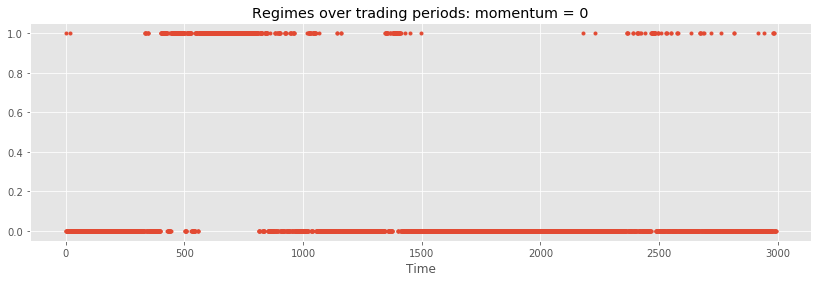

In [13]:
#regimes history
df_regime = pd.DataFrame(signals, columns = ['regime'])

plt.figure(figsize=(14, 4))
plt.plot(df_regime['regime'] ,'.') 
plt.xlabel("Time")
plt.title("Regimes over trading periods: momentum = 0")
plt.show()

In [14]:
#summary statistics for pure momentun strategy
risk_free = 0.
mo_daily_return, mo_mon_return, mo_cum_return = return_cal(mo_wealth_path)    
mo_df_cum_ret = pd.DataFrame(mo_cum_return, columns=['mo_cumulative return']) 
mo_df_daily_ret =  pd.DataFrame(mo_daily_return, columns=['mo_daily return']) 
mo_df_mon_ret = pd.DataFrame(mo_mon_return, columns=['mo_monthly returns'])
mo_annual_ret, mo_sharpe_ratio, mo_r_std, mo_sharpe_annual = summary_stats(mo_cum_return, mo_daily_return, risk_free)

print('pure_momentum :         CAGR = ', mo_annual_ret*100, '%  Sharpe Ratio = ', mo_sharpe_ratio, ' daily volatility = ', mo_r_std)

pure_momentum :         CAGR =  10.6148309021 %  Sharpe Ratio =  0.03668909422  daily volatility =  0.013289391070295248


Text(0.5,1,'mo_monthly returns')

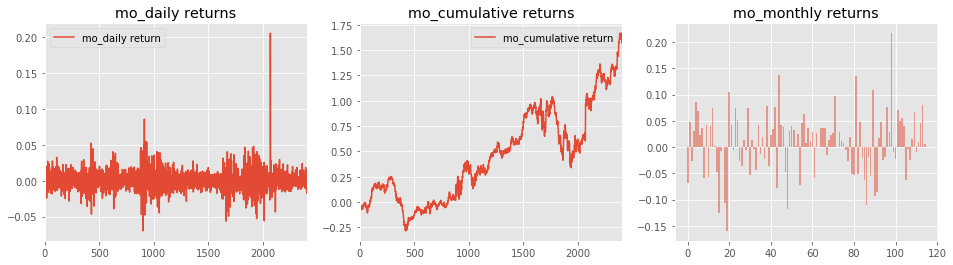

In [15]:
# plot return figures for momentum
fig = figure(figsize=[16, 4])
ax1 = fig.add_subplot(131)
mo_df_daily_ret.plot(ax = ax1, title = 'mo_daily returns')
ax2 = fig.add_subplot(132)
mo_df_cum_ret.plot(ax=ax2, title='mo_cumulative returns')
ax3 = fig.add_subplot(133)
mnum = int(len(mo_wealth_path)/21)+1
x = np.arange(mnum)
plt.bar(x, mo_mon_return,  alpha = 0.5)
plt.title('mo_monthly returns')

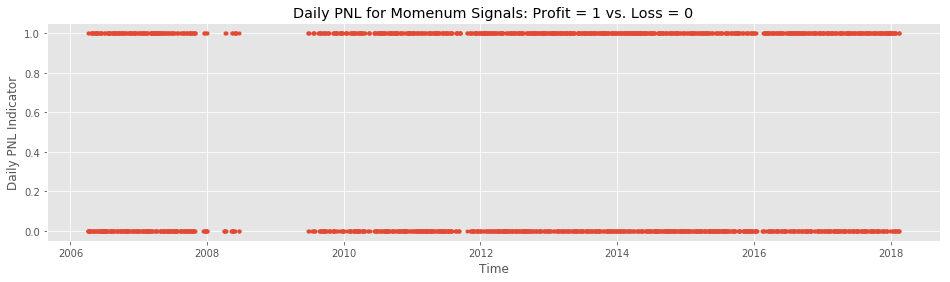

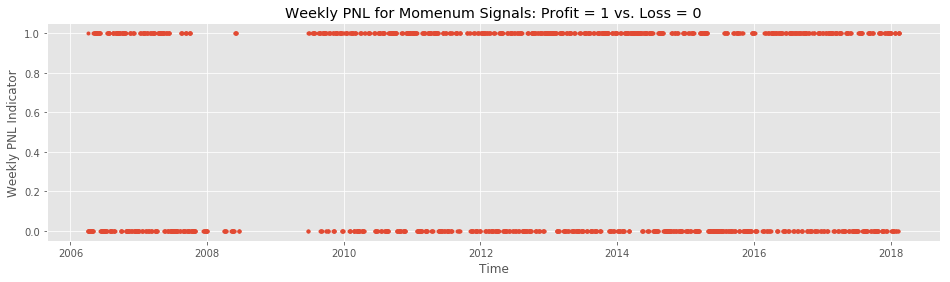

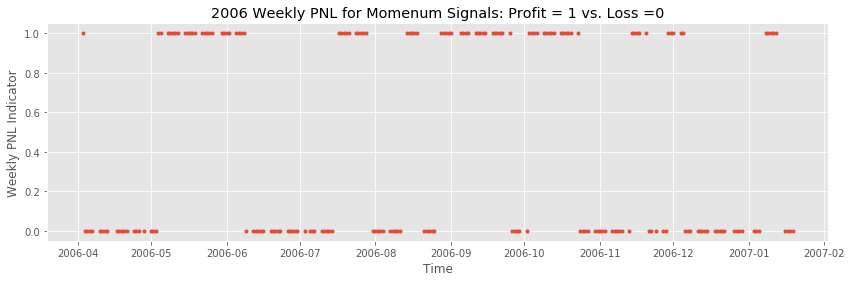

In [16]:
# plot PNL figures for momentum
#daily
plt.figure(figsize=(16, 4))
plt.plot(mo_df['Daily_PNL_Indi'] ,'.') 
plt.xlabel("Time")
plt.ylabel("Daily PNL Indicator")
plt.title("Daily PNL for Momenum Signals: Profit = 1 vs. Loss = 0")
plt.show()

#weekly
plt.figure(figsize=(16, 4))
plt.plot(mo_df['Weekly_PNL_Indi'] ,'.') 
plt.xlabel("Time")
plt.ylabel("Weekly PNL Indicator")
plt.title("Weekly PNL for Momenum Signals: Profit = 1 vs. Loss = 0")
plt.show()


# plot figures for sub period 2006
plt.figure(figsize=(14, 4))
plt.plot(mo_df['Weekly_PNL_Indi'].iloc[:200] ,'.') 
plt.xlabel("Time")
plt.ylabel("Weekly PNL Indicator")
plt.title("2006 Weekly PNL for Momenum Signals: Profit = 1 vs. Loss =0")
plt.show()




In [17]:
print( 'PNL for Momentum Regimes with Momentum Strategies: Profit = 1 vs. Loss = 0 ')
print('Mean reversion periods are not traded.')
fmt.display(mo_df)

PNL for Momentum Regimes with Momentum Strategies: Profit = 1 vs. Loss = 0 
Mean reversion periods are not traded.


,Regime signals,Daily_PNL_Indi,Weekly_PNL_Indi,Daily_PNL,Weekly_PNL
Date,,,,,
2006-04-03,0,1,1,0.000000,0.000000
2006-04-04,0,0,0,-4427.115054,-27904.585265
2006-04-05,0,0,0,-7044.591680,-27904.585265
2006-04-06,0,0,0,-6365.358744,-27904.585265
2006-04-07,0,0,0,-1756.190460,-27904.585265
2006-04-10,0,0,0,-8311.329328,-27904.585265
2006-04-11,0,0,0,-10909.483225,-31508.090808
2006-04-12,0,1,0,5336.557939,-31508.090808
2006-04-13,0,0,0,-4334.500156,-31508.090808


Example: first 9 momentum trading days in 2006


,XLE,XLB,XLF,XLV,XLY,XLP,wealth_path
Date,,,,,,,
2006-04-03,43.347473,24.967606,15.994549,26.058111,28.209604,17.427660,1000000.000000
2006-04-04,43.918034,25.005716,16.166271,26.090725,28.369402,17.412945,995572.884946
2006-04-05,44.639179,25.348793,16.195709,26.009192,28.554447,17.449739,988528.293266
2006-04-06,44.734261,25.402151,16.136831,25.813511,28.613306,17.383507,982162.934523
2006-04-07,43.862572,25.013359,15.984734,25.503691,28.487158,17.228956,980406.744063
2006-04-10,44.694649,25.005716,16.014175,25.454758,28.445099,17.251034,972095.414735
2006-04-11,44.377670,24.822748,15.876797,25.177549,28.218006,17.089117,961185.931510
2006-04-12,44.084450,24.990477,15.911142,25.348774,28.192787,17.147993,966522.489449
2006-04-13,44.227093,25.120079,15.935672,25.291700,28.260067,17.118559,962187.989293


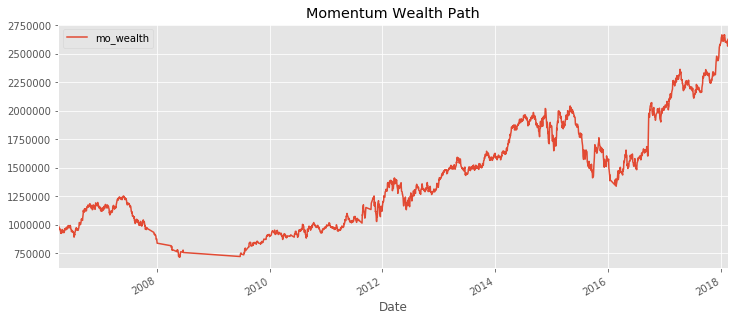

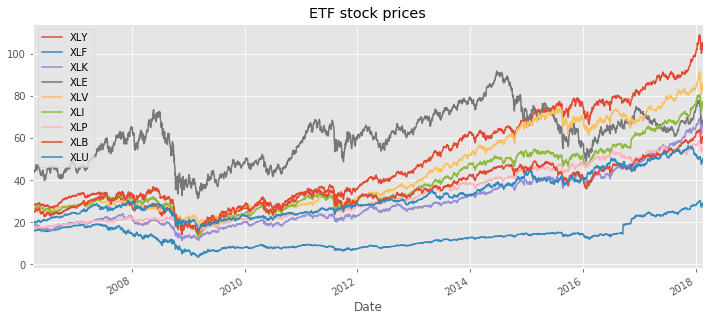

In [18]:
# Sample momentum trading periods
# ETF stock prices traded in April 2016
select_prices = prices[[tickers[3], tickers[7], tickers[1], tickers[4], tickers[0], tickers[6]]]
select_prices = select_prices[1:10]

# transform mo_wealth_path into dataframe
w_df = pd.DataFrame(mo_wealth_path, columns=['mo_wealth'], index = mo_df.index)
w_df.plot(title = 'Momentum Wealth Path', figsize = (12,5))

print('Example: first 9 momentum trading days in 2006')
w_df = w_df[:9]
select_prices['wealth_path'] = w_df
fmt.display(select_prices)


prices.plot(title = 'ETF stock prices', figsize = (12,5))

# Part II Mean-Reversion
1. Trade mean-reversion strategies in periods identified as mean-reversion regime. No trade happening in momentum regime.
2. Do PnL analysis to check if we are making profit or loss in the mean-reversion trading.


In [19]:

def pure_mean_reversion(signals, wealth, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates):
    
    # list initialization 
    position = []  
    stock_track = []
    wealth_path = [] 
    del_row = []
    wealthss =[]

    
    prices = ETF_close.iloc[t0:, :]
    regimes = ['no trading', 'mean-reversion']
    periods = len(prices)


    # seartch the first mean reversion trading period       
    k = 0
    while (signals[k] != 1):
        print('date = ', dates[k], 't = ', k, ' signal = ', signals[k], '  no trading')
        df = ETF_close.iloc[t0+k,:]
        data_mr = data_mr.drop(data_mr.index[0])
        data_mr = data_mr.append(df)
        del_row.append(dates[k])
        k += 1
        
    flag = True
    stocks = return_sort(data_mr, tnum, bnum)
    pl, ph = ppair(k, stocks, prices)
    pos = mean_revert_position(wealth, pl, ph)
    count_mr = 1
    regime_state = 1

    position.append(pos)
    stock_track.append(stocks)
    wealth_path.append(wealth)
    wealthss.append(wealth)
    df = ETF_close.iloc[t0+k,:]
    data_mr = data_mr.drop(data_mr.index[0])
    data_mr = data_mr.append(df)
    print('date = ', dates[k], 't = ', k,  '  mean-reversion   ', ' wealth = ', wealth_path[-1])

        
    
    for t in range(k+1,prices.shape[0]):
        signal = signals[t]
        if (regime_state == 1 and signal == 1):
            # continous mean-reversion
            if (count_mr % k_mr == 0 ):
                # update portfolio every k_mr days
                stocks = stock_track[-1]                
                pos, wealth, stocks = mean_reversion_build(t, stocks, prices, position, data_mr, tnum, bnum)
                
            else:
                pos = position[-1]
                stocks = stock_track[-1]
                wealth = wealth_cal(pos, stocks, t, prices)
            
            count_mr +=1
            flag = True
            position.append(pos)
            wealth_path.append(wealth)
            stock_track.append(stocks) 
             
        
        elif ( regime_state == 0 and signal == 1):
            # new mean reversion
            wealth = wealth_path[-1]
            stocks = return_sort(data_mr, tnum, bnum)
            pl, ph = ppair(t, stocks, prices)
            pos = mean_revert_position(wealth, pl, ph)
            count_mr = 1
            regime_state = 1
            flag = True
            position.append(pos)
            stock_track.append(stocks)
        
        else:
            # non-mean-reversion, no trading
            regime_state = 0
            del_row.append(dates[t])
            
            # if last period was trading, close position
            if (flag == True):
                stocks = stock_track[-1]
                pl, ph = ppair(t, stocks, prices) #current stock prices
                wealth = close(position, pl, ph)
                wealth_path.append(wealth)
            flag = False
            
        
        print('date = ', dates[t], 't = ', t, '  ', regimes[signal], '  wealth = ', wealth_path[-1]) 
        wealthss.append(wealth_path[-1])
        # update data for returns
        df = ETF_close.iloc[t0+t,:]
        data_mr = data_mr.drop(data_mr.index[0])
        data_mr = data_mr.append(df)
               
    return wealth_path, stock_track, position, del_row, wealthss


In [23]:
# trade pure mean-reversion strategy in periods identified as momentum

mr_wealth_path, mr_stock_track, mr_position, mr_del_row, mr_wealthss = pure_mean_reversion(signals, wealth0, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)


date =  2006-03-31 00:00:00 t =  0   mean-reversion     wealth =  1000000.0
date =  2006-04-03 00:00:00 t =  1    no trading   wealth =  1013550.46711
date =  2006-04-04 00:00:00 t =  2    no trading   wealth =  1013550.46711
date =  2006-04-05 00:00:00 t =  3    no trading   wealth =  1013550.46711
date =  2006-04-06 00:00:00 t =  4    no trading   wealth =  1013550.46711
date =  2006-04-07 00:00:00 t =  5    no trading   wealth =  1013550.46711
date =  2006-04-10 00:00:00 t =  6    no trading   wealth =  1013550.46711
date =  2006-04-11 00:00:00 t =  7    no trading   wealth =  1013550.46711
date =  2006-04-12 00:00:00 t =  8    no trading   wealth =  1013550.46711
date =  2006-04-13 00:00:00 t =  9    no trading   wealth =  1013550.46711
date =  2006-04-17 00:00:00 t =  10    no trading   wealth =  1013550.46711
date =  2006-04-18 00:00:00 t =  11    no trading   wealth =  1013550.46711
date =  2006-04-19 00:00:00 t =  12    no trading   wealth =  1013550.46711
date =  2006-04-20 00

date =  2006-10-03 00:00:00 t =  128    no trading   wealth =  1017201.78529
date =  2006-10-04 00:00:00 t =  129    no trading   wealth =  1017201.78529
date =  2006-10-05 00:00:00 t =  130    no trading   wealth =  1017201.78529
date =  2006-10-06 00:00:00 t =  131    no trading   wealth =  1017201.78529
date =  2006-10-09 00:00:00 t =  132    no trading   wealth =  1017201.78529
date =  2006-10-10 00:00:00 t =  133    no trading   wealth =  1017201.78529
date =  2006-10-11 00:00:00 t =  134    no trading   wealth =  1017201.78529
date =  2006-10-12 00:00:00 t =  135    no trading   wealth =  1017201.78529
date =  2006-10-13 00:00:00 t =  136    no trading   wealth =  1017201.78529
date =  2006-10-16 00:00:00 t =  137    no trading   wealth =  1017201.78529
date =  2006-10-17 00:00:00 t =  138    no trading   wealth =  1017201.78529
date =  2006-10-18 00:00:00 t =  139    no trading   wealth =  1017201.78529
date =  2006-10-19 00:00:00 t =  140    no trading   wealth =  1017201.78529

date =  2007-05-15 00:00:00 t =  281    no trading   wealth =  1017201.78529
date =  2007-05-16 00:00:00 t =  282    no trading   wealth =  1017201.78529
date =  2007-05-17 00:00:00 t =  283    no trading   wealth =  1017201.78529
date =  2007-05-18 00:00:00 t =  284    no trading   wealth =  1017201.78529
date =  2007-05-21 00:00:00 t =  285    no trading   wealth =  1017201.78529
date =  2007-05-22 00:00:00 t =  286    no trading   wealth =  1017201.78529
date =  2007-05-23 00:00:00 t =  287    no trading   wealth =  1017201.78529
date =  2007-05-24 00:00:00 t =  288    no trading   wealth =  1017201.78529
date =  2007-05-25 00:00:00 t =  289    no trading   wealth =  1017201.78529
date =  2007-05-29 00:00:00 t =  290    no trading   wealth =  1017201.78529
date =  2007-05-30 00:00:00 t =  291    no trading   wealth =  1017201.78529
date =  2007-05-31 00:00:00 t =  292    no trading   wealth =  1017201.78529
date =  2007-06-01 00:00:00 t =  293    no trading   wealth =  1017201.78529

date =  2008-03-28 00:00:00 t =  500    mean-reversion   wealth =  720461.972387
date =  2008-03-31 00:00:00 t =  501    mean-reversion   wealth =  721392.704015
date =  2008-04-01 00:00:00 t =  502    mean-reversion   wealth =  719956.129748
date =  2008-04-02 00:00:00 t =  503    no trading   wealth =  732004.909698
date =  2008-04-03 00:00:00 t =  504    no trading   wealth =  732004.909698
date =  2008-04-04 00:00:00 t =  505    no trading   wealth =  732004.909698
date =  2008-04-07 00:00:00 t =  506    no trading   wealth =  732004.909698
date =  2008-04-08 00:00:00 t =  507    no trading   wealth =  732004.909698
date =  2008-04-09 00:00:00 t =  508    no trading   wealth =  732004.909698
date =  2008-04-10 00:00:00 t =  509    no trading   wealth =  732004.909698
date =  2008-04-11 00:00:00 t =  510    mean-reversion   wealth =  732004.909698
date =  2008-04-14 00:00:00 t =  511    mean-reversion   wealth =  742595.587185
date =  2008-04-15 00:00:00 t =  512    mean-reversion  

date =  2008-09-30 00:00:00 t =  629    mean-reversion   wealth =  748975.110283
date =  2008-10-01 00:00:00 t =  630    mean-reversion   wealth =  781853.048374
date =  2008-10-02 00:00:00 t =  631    mean-reversion   wealth =  794704.783547
date =  2008-10-03 00:00:00 t =  632    mean-reversion   wealth =  767550.590326
date =  2008-10-06 00:00:00 t =  633    mean-reversion   wealth =  740694.844126
date =  2008-10-07 00:00:00 t =  634    mean-reversion   wealth =  697114.531104
date =  2008-10-08 00:00:00 t =  635    mean-reversion   wealth =  657707.987733
date =  2008-10-09 00:00:00 t =  636    mean-reversion   wealth =  587612.057999
date =  2008-10-10 00:00:00 t =  637    mean-reversion   wealth =  620795.63812
date =  2008-10-13 00:00:00 t =  638    mean-reversion   wealth =  646193.284107
date =  2008-10-14 00:00:00 t =  639    mean-reversion   wealth =  697865.543649
date =  2008-10-15 00:00:00 t =  640    mean-reversion   wealth =  654328.116856
date =  2008-10-16 00:00:00 t

date =  2009-03-26 00:00:00 t =  751    mean-reversion   wealth =  694529.20044
date =  2009-03-27 00:00:00 t =  752    mean-reversion   wealth =  667513.662001
date =  2009-03-30 00:00:00 t =  753    mean-reversion   wealth =  610874.452289
date =  2009-03-31 00:00:00 t =  754    mean-reversion   wealth =  640345.37254
date =  2009-04-01 00:00:00 t =  755    mean-reversion   wealth =  669119.248093
date =  2009-04-02 00:00:00 t =  756    mean-reversion   wealth =  701311.761726
date =  2009-04-03 00:00:00 t =  757    mean-reversion   wealth =  735011.782132
date =  2009-04-06 00:00:00 t =  758    mean-reversion   wealth =  708665.094544
date =  2009-04-07 00:00:00 t =  759    mean-reversion   wealth =  674128.444819
date =  2009-04-08 00:00:00 t =  760    mean-reversion   wealth =  682949.00784
date =  2009-04-09 00:00:00 t =  761    mean-reversion   wealth =  784218.034729
date =  2009-04-13 00:00:00 t =  762    mean-reversion   wealth =  814280.63813
date =  2009-04-14 00:00:00 t = 

date =  2009-10-09 00:00:00 t =  888    no trading   wealth =  885697.070856
date =  2009-10-12 00:00:00 t =  889    no trading   wealth =  885697.070856
date =  2009-10-13 00:00:00 t =  890    no trading   wealth =  885697.070856
date =  2009-10-14 00:00:00 t =  891    mean-reversion   wealth =  885697.070856
date =  2009-10-15 00:00:00 t =  892    mean-reversion   wealth =  894879.087238
date =  2009-10-16 00:00:00 t =  893    mean-reversion   wealth =  887478.796019
date =  2009-10-19 00:00:00 t =  894    no trading   wealth =  889532.012551
date =  2009-10-20 00:00:00 t =  895    no trading   wealth =  889532.012551
date =  2009-10-21 00:00:00 t =  896    no trading   wealth =  889532.012551
date =  2009-10-22 00:00:00 t =  897    mean-reversion   wealth =  889532.012551
date =  2009-10-23 00:00:00 t =  898    mean-reversion   wealth =  885297.940466
date =  2009-10-26 00:00:00 t =  899    mean-reversion   wealth =  884964.479299
date =  2009-10-27 00:00:00 t =  900    mean-reversi

date =  2010-04-07 00:00:00 t =  1010    no trading   wealth =  839718.686828
date =  2010-04-08 00:00:00 t =  1011    no trading   wealth =  839718.686828
date =  2010-04-09 00:00:00 t =  1012    no trading   wealth =  839718.686828
date =  2010-04-12 00:00:00 t =  1013    no trading   wealth =  839718.686828
date =  2010-04-13 00:00:00 t =  1014    no trading   wealth =  839718.686828
date =  2010-04-14 00:00:00 t =  1015    no trading   wealth =  839718.686828
date =  2010-04-15 00:00:00 t =  1016    no trading   wealth =  839718.686828
date =  2010-04-16 00:00:00 t =  1017    mean-reversion   wealth =  839718.686828
date =  2010-04-19 00:00:00 t =  1018    no trading   wealth =  841438.778658
date =  2010-04-20 00:00:00 t =  1019    no trading   wealth =  841438.778658
date =  2010-04-21 00:00:00 t =  1020    no trading   wealth =  841438.778658
date =  2010-04-22 00:00:00 t =  1021    no trading   wealth =  841438.778658
date =  2010-04-23 00:00:00 t =  1022    no trading   wealth

date =  2010-12-09 00:00:00 t =  1182    no trading   wealth =  735247.566538
date =  2010-12-10 00:00:00 t =  1183    no trading   wealth =  735247.566538
date =  2010-12-13 00:00:00 t =  1184    no trading   wealth =  735247.566538
date =  2010-12-14 00:00:00 t =  1185    no trading   wealth =  735247.566538
date =  2010-12-15 00:00:00 t =  1186    no trading   wealth =  735247.566538
date =  2010-12-16 00:00:00 t =  1187    no trading   wealth =  735247.566538
date =  2010-12-17 00:00:00 t =  1188    no trading   wealth =  735247.566538
date =  2010-12-20 00:00:00 t =  1189    no trading   wealth =  735247.566538
date =  2010-12-21 00:00:00 t =  1190    no trading   wealth =  735247.566538
date =  2010-12-22 00:00:00 t =  1191    no trading   wealth =  735247.566538
date =  2010-12-23 00:00:00 t =  1192    no trading   wealth =  735247.566538
date =  2010-12-27 00:00:00 t =  1193    no trading   wealth =  735247.566538
date =  2010-12-28 00:00:00 t =  1194    no trading   wealth =  

date =  2011-09-20 00:00:00 t =  1378    mean-reversion   wealth =  721560.622751
date =  2011-09-21 00:00:00 t =  1379    mean-reversion   wealth =  705887.894512
date =  2011-09-22 00:00:00 t =  1380    mean-reversion   wealth =  683905.551922
date =  2011-09-23 00:00:00 t =  1381    mean-reversion   wealth =  700119.865141
date =  2011-09-26 00:00:00 t =  1382    mean-reversion   wealth =  705674.55945
date =  2011-09-27 00:00:00 t =  1383    mean-reversion   wealth =  717178.495173
date =  2011-09-28 00:00:00 t =  1384    mean-reversion   wealth =  709018.818714
date =  2011-09-29 00:00:00 t =  1385    mean-reversion   wealth =  700012.828802
date =  2011-09-30 00:00:00 t =  1386    mean-reversion   wealth =  676699.337375
date =  2011-10-03 00:00:00 t =  1387    mean-reversion   wealth =  661665.415804
date =  2011-10-04 00:00:00 t =  1388    mean-reversion   wealth =  648128.30267
date =  2011-10-05 00:00:00 t =  1389    mean-reversion   wealth =  637533.777319
date =  2011-10-06

date =  2012-03-16 00:00:00 t =  1501    no trading   wealth =  675828.732835
date =  2012-03-19 00:00:00 t =  1502    no trading   wealth =  675828.732835
date =  2012-03-20 00:00:00 t =  1503    no trading   wealth =  675828.732835
date =  2012-03-21 00:00:00 t =  1504    no trading   wealth =  675828.732835
date =  2012-03-22 00:00:00 t =  1505    no trading   wealth =  675828.732835
date =  2012-03-23 00:00:00 t =  1506    no trading   wealth =  675828.732835
date =  2012-03-26 00:00:00 t =  1507    no trading   wealth =  675828.732835
date =  2012-03-27 00:00:00 t =  1508    no trading   wealth =  675828.732835
date =  2012-03-28 00:00:00 t =  1509    no trading   wealth =  675828.732835
date =  2012-03-29 00:00:00 t =  1510    no trading   wealth =  675828.732835
date =  2012-03-30 00:00:00 t =  1511    no trading   wealth =  675828.732835
date =  2012-04-02 00:00:00 t =  1512    no trading   wealth =  675828.732835
date =  2012-04-03 00:00:00 t =  1513    no trading   wealth =  

date =  2012-11-27 00:00:00 t =  1676    no trading   wealth =  675828.732835
date =  2012-11-28 00:00:00 t =  1677    no trading   wealth =  675828.732835
date =  2012-11-29 00:00:00 t =  1678    no trading   wealth =  675828.732835
date =  2012-11-30 00:00:00 t =  1679    no trading   wealth =  675828.732835
date =  2012-12-03 00:00:00 t =  1680    no trading   wealth =  675828.732835
date =  2012-12-04 00:00:00 t =  1681    no trading   wealth =  675828.732835
date =  2012-12-05 00:00:00 t =  1682    no trading   wealth =  675828.732835
date =  2012-12-06 00:00:00 t =  1683    no trading   wealth =  675828.732835
date =  2012-12-07 00:00:00 t =  1684    no trading   wealth =  675828.732835
date =  2012-12-10 00:00:00 t =  1685    no trading   wealth =  675828.732835
date =  2012-12-11 00:00:00 t =  1686    no trading   wealth =  675828.732835
date =  2012-12-12 00:00:00 t =  1687    no trading   wealth =  675828.732835
date =  2012-12-13 00:00:00 t =  1688    no trading   wealth =  

date =  2013-06-07 00:00:00 t =  1808    no trading   wealth =  675828.732835
date =  2013-06-10 00:00:00 t =  1809    no trading   wealth =  675828.732835
date =  2013-06-11 00:00:00 t =  1810    no trading   wealth =  675828.732835
date =  2013-06-12 00:00:00 t =  1811    no trading   wealth =  675828.732835
date =  2013-06-13 00:00:00 t =  1812    no trading   wealth =  675828.732835
date =  2013-06-14 00:00:00 t =  1813    no trading   wealth =  675828.732835
date =  2013-06-17 00:00:00 t =  1814    no trading   wealth =  675828.732835
date =  2013-06-18 00:00:00 t =  1815    no trading   wealth =  675828.732835
date =  2013-06-19 00:00:00 t =  1816    no trading   wealth =  675828.732835
date =  2013-06-20 00:00:00 t =  1817    no trading   wealth =  675828.732835
date =  2013-06-21 00:00:00 t =  1818    no trading   wealth =  675828.732835
date =  2013-06-24 00:00:00 t =  1819    no trading   wealth =  675828.732835
date =  2013-06-25 00:00:00 t =  1820    no trading   wealth =  

date =  2013-12-09 00:00:00 t =  1936    no trading   wealth =  675828.732835
date =  2013-12-10 00:00:00 t =  1937    no trading   wealth =  675828.732835
date =  2013-12-11 00:00:00 t =  1938    no trading   wealth =  675828.732835
date =  2013-12-12 00:00:00 t =  1939    no trading   wealth =  675828.732835
date =  2013-12-13 00:00:00 t =  1940    no trading   wealth =  675828.732835
date =  2013-12-16 00:00:00 t =  1941    no trading   wealth =  675828.732835
date =  2013-12-17 00:00:00 t =  1942    no trading   wealth =  675828.732835
date =  2013-12-18 00:00:00 t =  1943    no trading   wealth =  675828.732835
date =  2013-12-19 00:00:00 t =  1944    no trading   wealth =  675828.732835
date =  2013-12-20 00:00:00 t =  1945    no trading   wealth =  675828.732835
date =  2013-12-23 00:00:00 t =  1946    no trading   wealth =  675828.732835
date =  2013-12-24 00:00:00 t =  1947    no trading   wealth =  675828.732835
date =  2013-12-26 00:00:00 t =  1948    no trading   wealth =  

date =  2014-07-14 00:00:00 t =  2084    no trading   wealth =  675828.732835
date =  2014-07-15 00:00:00 t =  2085    no trading   wealth =  675828.732835
date =  2014-07-16 00:00:00 t =  2086    no trading   wealth =  675828.732835
date =  2014-07-17 00:00:00 t =  2087    no trading   wealth =  675828.732835
date =  2014-07-18 00:00:00 t =  2088    no trading   wealth =  675828.732835
date =  2014-07-21 00:00:00 t =  2089    no trading   wealth =  675828.732835
date =  2014-07-22 00:00:00 t =  2090    no trading   wealth =  675828.732835
date =  2014-07-23 00:00:00 t =  2091    no trading   wealth =  675828.732835
date =  2014-07-24 00:00:00 t =  2092    no trading   wealth =  675828.732835
date =  2014-07-25 00:00:00 t =  2093    no trading   wealth =  675828.732835
date =  2014-07-28 00:00:00 t =  2094    no trading   wealth =  675828.732835
date =  2014-07-29 00:00:00 t =  2095    no trading   wealth =  675828.732835
date =  2014-07-30 00:00:00 t =  2096    no trading   wealth =  

date =  2015-03-03 00:00:00 t =  2244    no trading   wealth =  665015.170088
date =  2015-03-04 00:00:00 t =  2245    no trading   wealth =  665015.170088
date =  2015-03-05 00:00:00 t =  2246    no trading   wealth =  665015.170088
date =  2015-03-06 00:00:00 t =  2247    no trading   wealth =  665015.170088
date =  2015-03-09 00:00:00 t =  2248    no trading   wealth =  665015.170088
date =  2015-03-10 00:00:00 t =  2249    no trading   wealth =  665015.170088
date =  2015-03-11 00:00:00 t =  2250    no trading   wealth =  665015.170088
date =  2015-03-12 00:00:00 t =  2251    no trading   wealth =  665015.170088
date =  2015-03-13 00:00:00 t =  2252    no trading   wealth =  665015.170088
date =  2015-03-16 00:00:00 t =  2253    no trading   wealth =  665015.170088
date =  2015-03-17 00:00:00 t =  2254    no trading   wealth =  665015.170088
date =  2015-03-18 00:00:00 t =  2255    no trading   wealth =  665015.170088
date =  2015-03-19 00:00:00 t =  2256    no trading   wealth =  

date =  2015-08-31 00:00:00 t =  2370    no trading   wealth =  644538.844725
date =  2015-09-01 00:00:00 t =  2371    no trading   wealth =  644538.844725
date =  2015-09-02 00:00:00 t =  2372    no trading   wealth =  644538.844725
date =  2015-09-03 00:00:00 t =  2373    no trading   wealth =  644538.844725
date =  2015-09-04 00:00:00 t =  2374    no trading   wealth =  644538.844725
date =  2015-09-08 00:00:00 t =  2375    no trading   wealth =  644538.844725
date =  2015-09-09 00:00:00 t =  2376    no trading   wealth =  644538.844725
date =  2015-09-10 00:00:00 t =  2377    no trading   wealth =  644538.844725
date =  2015-09-11 00:00:00 t =  2378    no trading   wealth =  644538.844725
date =  2015-09-14 00:00:00 t =  2379    no trading   wealth =  644538.844725
date =  2015-09-15 00:00:00 t =  2380    no trading   wealth =  644538.844725
date =  2015-09-16 00:00:00 t =  2381    no trading   wealth =  644538.844725
date =  2015-09-17 00:00:00 t =  2382    no trading   wealth =  

date =  2016-03-04 00:00:00 t =  2498    no trading   wealth =  567285.404313
date =  2016-03-07 00:00:00 t =  2499    no trading   wealth =  567285.404313
date =  2016-03-08 00:00:00 t =  2500    no trading   wealth =  567285.404313
date =  2016-03-09 00:00:00 t =  2501    no trading   wealth =  567285.404313
date =  2016-03-10 00:00:00 t =  2502    no trading   wealth =  567285.404313
date =  2016-03-11 00:00:00 t =  2503    no trading   wealth =  567285.404313
date =  2016-03-14 00:00:00 t =  2504    no trading   wealth =  567285.404313
date =  2016-03-15 00:00:00 t =  2505    no trading   wealth =  567285.404313
date =  2016-03-16 00:00:00 t =  2506    no trading   wealth =  567285.404313
date =  2016-03-17 00:00:00 t =  2507    mean-reversion   wealth =  567285.404313
date =  2016-03-18 00:00:00 t =  2508    no trading   wealth =  563926.989705
date =  2016-03-21 00:00:00 t =  2509    no trading   wealth =  563926.989705
date =  2016-03-22 00:00:00 t =  2510    no trading   wealth

date =  2016-09-02 00:00:00 t =  2625    no trading   wealth =  587376.140489
date =  2016-09-06 00:00:00 t =  2626    no trading   wealth =  587376.140489
date =  2016-09-07 00:00:00 t =  2627    no trading   wealth =  587376.140489
date =  2016-09-08 00:00:00 t =  2628    no trading   wealth =  587376.140489
date =  2016-09-09 00:00:00 t =  2629    no trading   wealth =  587376.140489
date =  2016-09-12 00:00:00 t =  2630    no trading   wealth =  587376.140489
date =  2016-09-13 00:00:00 t =  2631    no trading   wealth =  587376.140489
date =  2016-09-14 00:00:00 t =  2632    no trading   wealth =  587376.140489
date =  2016-09-15 00:00:00 t =  2633    no trading   wealth =  587376.140489
date =  2016-09-16 00:00:00 t =  2634    no trading   wealth =  587376.140489
date =  2016-09-19 00:00:00 t =  2635    mean-reversion   wealth =  587376.140489
date =  2016-09-20 00:00:00 t =  2636    no trading   wealth =  588457.54482
date =  2016-09-21 00:00:00 t =  2637    no trading   wealth 

date =  2017-03-07 00:00:00 t =  2751    no trading   wealth =  622167.40444
date =  2017-03-08 00:00:00 t =  2752    no trading   wealth =  622167.40444
date =  2017-03-09 00:00:00 t =  2753    no trading   wealth =  622167.40444
date =  2017-03-10 00:00:00 t =  2754    no trading   wealth =  622167.40444
date =  2017-03-13 00:00:00 t =  2755    no trading   wealth =  622167.40444
date =  2017-03-14 00:00:00 t =  2756    no trading   wealth =  622167.40444
date =  2017-03-15 00:00:00 t =  2757    no trading   wealth =  622167.40444
date =  2017-03-16 00:00:00 t =  2758    no trading   wealth =  622167.40444
date =  2017-03-17 00:00:00 t =  2759    no trading   wealth =  622167.40444
date =  2017-03-20 00:00:00 t =  2760    no trading   wealth =  622167.40444
date =  2017-03-21 00:00:00 t =  2761    mean-reversion   wealth =  622167.40444
date =  2017-03-22 00:00:00 t =  2762    no trading   wealth =  626890.417839
date =  2017-03-23 00:00:00 t =  2763    no trading   wealth =  626890.

date =  2017-09-13 00:00:00 t =  2883    no trading   wealth =  602514.476748
date =  2017-09-14 00:00:00 t =  2884    no trading   wealth =  602514.476748
date =  2017-09-15 00:00:00 t =  2885    no trading   wealth =  602514.476748
date =  2017-09-18 00:00:00 t =  2886    no trading   wealth =  602514.476748
date =  2017-09-19 00:00:00 t =  2887    no trading   wealth =  602514.476748
date =  2017-09-20 00:00:00 t =  2888    no trading   wealth =  602514.476748
date =  2017-09-21 00:00:00 t =  2889    no trading   wealth =  602514.476748
date =  2017-09-22 00:00:00 t =  2890    no trading   wealth =  602514.476748
date =  2017-09-25 00:00:00 t =  2891    no trading   wealth =  602514.476748
date =  2017-09-26 00:00:00 t =  2892    no trading   wealth =  602514.476748
date =  2017-09-27 00:00:00 t =  2893    no trading   wealth =  602514.476748
date =  2017-09-28 00:00:00 t =  2894    no trading   wealth =  602514.476748
date =  2017-09-29 00:00:00 t =  2895    no trading   wealth =  

In [21]:
# PNL analysis for periods that we trade mean-reversion strategies when it signals mean-reversion
# no trades happening during momentum signals. 

mr_df = pd.DataFrame(signals, index = dates, columns =['Regime signals'])
mr_df = mr_df.drop(mr_del_row, axis = 0)

df_len = len(mr_df)
mr_pnl_daily, mr_pnl_indi_daily = pnl_cal(df_len, mr_wealth_path,1)
mr_df['Daily_PNL_Indi'] = mr_pnl_indi_daily

mr_pnl_weekly, mr_pnl_indi_weekly = pnl_cal(df_len, mr_wealth_path,5)
mr_df['Weekly_PNL_Indi'] = mr_pnl_indi_weekly

mr_df['Daily_PNL'] = mr_pnl_daily
mr_df['Weekly_PNL'] = mr_pnl_weekly



In [22]:

#summary statistics for pure mean-reversion strategy
risk_free = 0.
mr_daily_return, mr_mon_return, mr_cum_return = return_cal(mr_wealth_path)    
mr_df_cum_ret = pd.DataFrame(mr_cum_return, columns=['mr_cumulative return']) 
mr_df_daily_ret =  pd.DataFrame(mr_daily_return, columns=['mr_daily return']) 
mr_df_mon_ret = pd.DataFrame(mr_mon_return, columns=['mr_monthly returns'])
mr_annual_ret, mr_sharpe_ratio, mr_r_std, mr_sharpe_annual = summary_stats(mr_cum_return, mr_daily_return, risk_free)

print('pure_mean_reversion :   CAGR = ', mr_annual_ret*100, '%  Sharpe Ratio = ', mr_sharpe_ratio, ' daily volatility = ', mr_r_std)



pure_mean_reversion :   CAGR =  -20.763977461 %  Sharpe Ratio =  -0.0182223766978  daily volatility =  0.028478265619108774


Text(0.5,1,'mr_monthly returns')

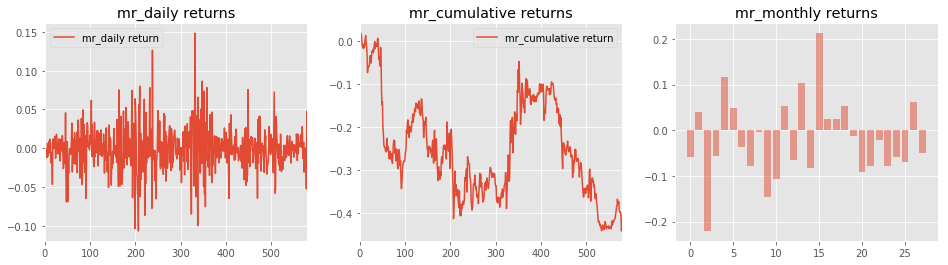

In [23]:
# plot return figures for mean-reversion
fig = figure(figsize=[16, 4])
ax1 = fig.add_subplot(131)
mr_df_daily_ret.plot(ax = ax1, title = 'mr_daily returns')
ax2 = fig.add_subplot(132)
mr_df_cum_ret.plot(ax=ax2, title='mr_cumulative returns')
ax3 = fig.add_subplot(133)
mnum = int(len(mr_wealth_path)/21)+1
x = np.arange(mnum)
plt.bar(x, mr_mon_return,  alpha = 0.5)
plt.title('mr_monthly returns')

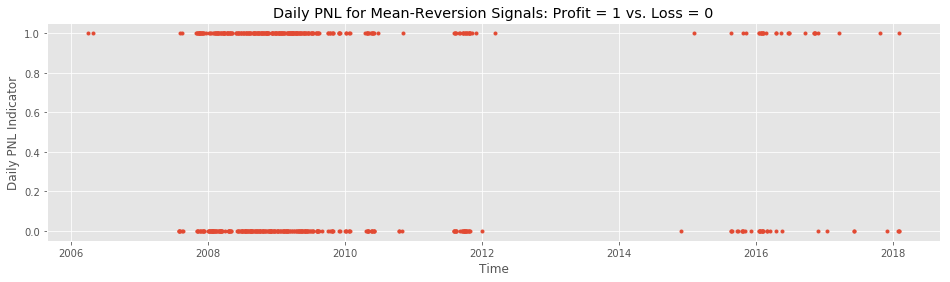

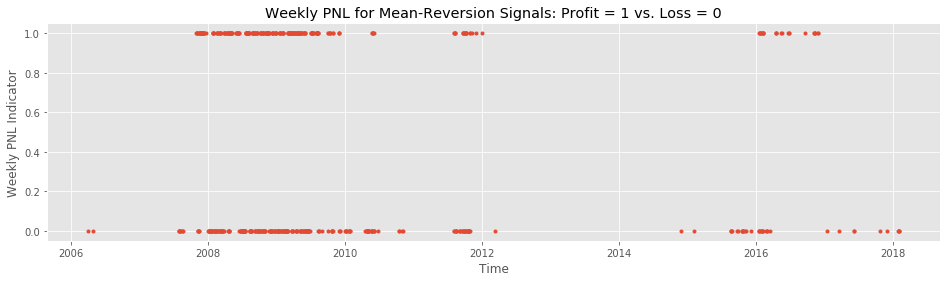

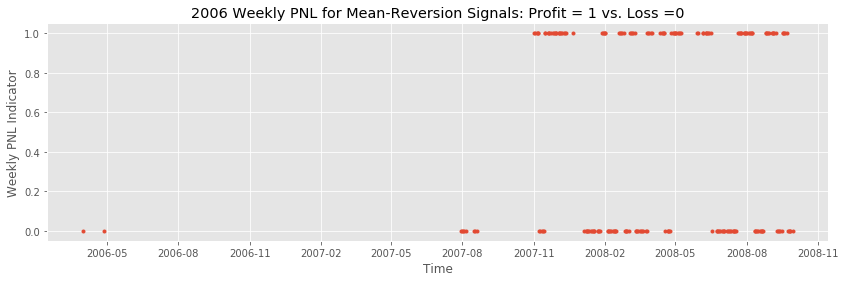

In [24]:
# plot PNL figures for mean-reversion
# daily
plt.figure(figsize=(16, 4))
plt.plot(mr_df['Daily_PNL_Indi'] ,'.') 
plt.xlabel("Time")
plt.ylabel("Daily PNL Indicator")
plt.title("Daily PNL for Mean-Reversion Signals: Profit = 1 vs. Loss = 0")
plt.show()


# weekly
plt.figure(figsize=(16, 4))
plt.plot(mr_df['Weekly_PNL_Indi'] ,'.') 
plt.xlabel("Time")
plt.ylabel("Weekly PNL Indicator")
plt.title("Weekly PNL for Mean-Reversion Signals: Profit = 1 vs. Loss = 0")
plt.show()


# plot figure for sub period 2006
plt.figure(figsize=(14, 4))
plt.plot(mr_df['Weekly_PNL_Indi'].iloc[:200] ,'.') 
plt.xlabel("Time")
plt.ylabel("Weekly PNL Indicator")
plt.title("2006 Weekly PNL for Mean-Reversion Signals: Profit = 1 vs. Loss =0")
plt.show()

In [25]:
print( 'PNL for Mean-Reversion Regimes with Mean-Reversion Strategies: Profit = 1 vs. Loss = 0 ')
print('Momentum periods are not traded.')
fmt.display(mr_df)

PNL for Mean-Reversion Regimes with Mean-Reversion Strategies: Profit = 1 vs. Loss = 0 
Momentum periods are not traded.


,Regime signals,Daily_PNL_Indi,Weekly_PNL_Indi,Daily_PNL,Weekly_PNL
Date,,,,,
2006-03-31,1,1,0,13550.467114,-6008.584509
2006-04-27,1,1,0,3651.318180,-6008.584509
2007-07-31,1,0,0,-2088.640299,-6008.584509
2007-08-01,1,0,0,-8968.273584,-6008.584509
2007-08-02,1,0,0,-12153.455921,-6008.584509
2007-08-03,1,0,0,-8331.124461,-9594.883241
2007-08-06,1,1,0,5925.773698,-9594.883241
2007-08-16,1,0,0,-9833.818842,-9594.883241
2007-08-17,1,1,0,8295.787490,-9594.883241


# Cross PNL
1. Trade mean-reversion strategy in periods identified as momentum
2. Trade momentum strategy in periods identified as mean-reversion

In [20]:
# reverse signals
# signal_x = 1 - signal

# signal_x = 1 is mean-reversion after reverse
# signal_x = 1 is momentum in original signals

signals_x = [1]*len(signals)
signals_x = np.subtract(signals_x,signals)
# mean-reversion originally
mo_wealth_path_x, mo_stock_track_x, mo_position_x, mo_del_row_x, mo_wealthss_x = pure_momentum(signals_x, wealth0, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)


date =  2006-03-31 00:00:00 t =  0   momentum     wealth =  1000000.0
date =  2006-04-03 00:00:00 t =  1    no trading   wealth =  992994.237688
date =  2006-04-04 00:00:00 t =  2    no trading   wealth =  992994.237688
date =  2006-04-05 00:00:00 t =  3    no trading   wealth =  992994.237688
date =  2006-04-06 00:00:00 t =  4    no trading   wealth =  992994.237688
date =  2006-04-07 00:00:00 t =  5    no trading   wealth =  992994.237688
date =  2006-04-10 00:00:00 t =  6    no trading   wealth =  992994.237688
date =  2006-04-11 00:00:00 t =  7    no trading   wealth =  992994.237688
date =  2006-04-12 00:00:00 t =  8    no trading   wealth =  992994.237688
date =  2006-04-13 00:00:00 t =  9    no trading   wealth =  992994.237688
date =  2006-04-17 00:00:00 t =  10    no trading   wealth =  992994.237688
date =  2006-04-18 00:00:00 t =  11    no trading   wealth =  992994.237688
date =  2006-04-19 00:00:00 t =  12    no trading   wealth =  992994.237688
date =  2006-04-20 00:00:00

date =  2006-10-09 00:00:00 t =  132    no trading   wealth =  997485.768859
date =  2006-10-10 00:00:00 t =  133    no trading   wealth =  997485.768859
date =  2006-10-11 00:00:00 t =  134    no trading   wealth =  997485.768859
date =  2006-10-12 00:00:00 t =  135    no trading   wealth =  997485.768859
date =  2006-10-13 00:00:00 t =  136    no trading   wealth =  997485.768859
date =  2006-10-16 00:00:00 t =  137    no trading   wealth =  997485.768859
date =  2006-10-17 00:00:00 t =  138    no trading   wealth =  997485.768859
date =  2006-10-18 00:00:00 t =  139    no trading   wealth =  997485.768859
date =  2006-10-19 00:00:00 t =  140    no trading   wealth =  997485.768859
date =  2006-10-20 00:00:00 t =  141    no trading   wealth =  997485.768859
date =  2006-10-23 00:00:00 t =  142    no trading   wealth =  997485.768859
date =  2006-10-24 00:00:00 t =  143    no trading   wealth =  997485.768859
date =  2006-10-25 00:00:00 t =  144    no trading   wealth =  997485.768859

date =  2007-04-05 00:00:00 t =  254    no trading   wealth =  997485.768859
date =  2007-04-09 00:00:00 t =  255    no trading   wealth =  997485.768859
date =  2007-04-10 00:00:00 t =  256    no trading   wealth =  997485.768859
date =  2007-04-11 00:00:00 t =  257    no trading   wealth =  997485.768859
date =  2007-04-12 00:00:00 t =  258    no trading   wealth =  997485.768859
date =  2007-04-13 00:00:00 t =  259    no trading   wealth =  997485.768859
date =  2007-04-16 00:00:00 t =  260    no trading   wealth =  997485.768859
date =  2007-04-17 00:00:00 t =  261    no trading   wealth =  997485.768859
date =  2007-04-18 00:00:00 t =  262    no trading   wealth =  997485.768859
date =  2007-04-19 00:00:00 t =  263    no trading   wealth =  997485.768859
date =  2007-04-20 00:00:00 t =  264    no trading   wealth =  997485.768859
date =  2007-04-23 00:00:00 t =  265    no trading   wealth =  997485.768859
date =  2007-04-24 00:00:00 t =  266    no trading   wealth =  997485.768859

date =  2007-09-28 00:00:00 t =  376    no trading   wealth =  1084048.63475
date =  2007-10-01 00:00:00 t =  377    no trading   wealth =  1084048.63475
date =  2007-10-02 00:00:00 t =  378    no trading   wealth =  1084048.63475
date =  2007-10-03 00:00:00 t =  379    no trading   wealth =  1084048.63475
date =  2007-10-04 00:00:00 t =  380    no trading   wealth =  1084048.63475
date =  2007-10-05 00:00:00 t =  381    no trading   wealth =  1084048.63475
date =  2007-10-08 00:00:00 t =  382    no trading   wealth =  1084048.63475
date =  2007-10-09 00:00:00 t =  383    no trading   wealth =  1084048.63475
date =  2007-10-10 00:00:00 t =  384    no trading   wealth =  1084048.63475
date =  2007-10-11 00:00:00 t =  385    no trading   wealth =  1084048.63475
date =  2007-10-12 00:00:00 t =  386    no trading   wealth =  1084048.63475
date =  2007-10-15 00:00:00 t =  387    no trading   wealth =  1084048.63475
date =  2007-10-16 00:00:00 t =  388    no trading   wealth =  1084048.63475

date =  2008-03-27 00:00:00 t =  499    momentum   wealth =  959822.620782
date =  2008-03-28 00:00:00 t =  500    momentum   wealth =  935256.416826
date =  2008-03-31 00:00:00 t =  501    momentum   wealth =  939562.3281
date =  2008-04-01 00:00:00 t =  502    momentum   wealth =  1002786.34954
date =  2008-04-02 00:00:00 t =  503    no trading   wealth =  991558.828711
date =  2008-04-03 00:00:00 t =  504    no trading   wealth =  991558.828711
date =  2008-04-04 00:00:00 t =  505    no trading   wealth =  991558.828711
date =  2008-04-07 00:00:00 t =  506    no trading   wealth =  991558.828711
date =  2008-04-08 00:00:00 t =  507    no trading   wealth =  991558.828711
date =  2008-04-09 00:00:00 t =  508    no trading   wealth =  991558.828711
date =  2008-04-10 00:00:00 t =  509    no trading   wealth =  991558.828711
date =  2008-04-11 00:00:00 t =  510    momentum   wealth =  991558.828711
date =  2008-04-14 00:00:00 t =  511    momentum   wealth =  962572.35981
date =  2008-0

date =  2008-09-25 00:00:00 t =  626    momentum   wealth =  925528.295813
date =  2008-09-26 00:00:00 t =  627    momentum   wealth =  958505.442268
date =  2008-09-29 00:00:00 t =  628    momentum   wealth =  868752.174817
date =  2008-09-30 00:00:00 t =  629    momentum   wealth =  906683.199747
date =  2008-10-01 00:00:00 t =  630    momentum   wealth =  917231.949299
date =  2008-10-02 00:00:00 t =  631    momentum   wealth =  868493.872814
date =  2008-10-03 00:00:00 t =  632    momentum   wealth =  834690.621971
date =  2008-10-06 00:00:00 t =  633    momentum   wealth =  795726.845004
date =  2008-10-07 00:00:00 t =  634    momentum   wealth =  731065.747074
date =  2008-10-08 00:00:00 t =  635    momentum   wealth =  696819.876343
date =  2008-10-09 00:00:00 t =  636    momentum   wealth =  669926.859294
date =  2008-10-10 00:00:00 t =  637    momentum   wealth =  704412.271467
date =  2008-10-13 00:00:00 t =  638    momentum   wealth =  769672.406322
date =  2008-10-14 00:00:

date =  2009-04-01 00:00:00 t =  755    momentum   wealth =  434739.461363
date =  2009-04-02 00:00:00 t =  756    momentum   wealth =  463434.619184
date =  2009-04-03 00:00:00 t =  757    momentum   wealth =  481479.461017
date =  2009-04-06 00:00:00 t =  758    momentum   wealth =  468220.022672
date =  2009-04-07 00:00:00 t =  759    momentum   wealth =  445462.247766
date =  2009-04-08 00:00:00 t =  760    momentum   wealth =  449424.60374
date =  2009-04-09 00:00:00 t =  761    momentum   wealth =  520763.613479
date =  2009-04-13 00:00:00 t =  762    momentum   wealth =  540880.335907
date =  2009-04-14 00:00:00 t =  763    momentum   wealth =  512126.085659
date =  2009-04-15 00:00:00 t =  764    momentum   wealth =  533165.590051
date =  2009-04-16 00:00:00 t =  765    momentum   wealth =  544056.985746
date =  2009-04-17 00:00:00 t =  766    momentum   wealth =  548426.105413
date =  2009-04-20 00:00:00 t =  767    momentum   wealth =  488223.391279
date =  2009-04-21 00:00:0

date =  2009-09-28 00:00:00 t =  879    no trading   wealth =  643172.267421
date =  2009-09-29 00:00:00 t =  880    no trading   wealth =  643172.267421
date =  2009-09-30 00:00:00 t =  881    no trading   wealth =  643172.267421
date =  2009-10-01 00:00:00 t =  882    momentum   wealth =  643172.267421
date =  2009-10-02 00:00:00 t =  883    momentum   wealth =  641132.987116
date =  2009-10-05 00:00:00 t =  884    momentum   wealth =  642569.59177
date =  2009-10-06 00:00:00 t =  885    no trading   wealth =  649425.296114
date =  2009-10-07 00:00:00 t =  886    no trading   wealth =  649425.296114
date =  2009-10-08 00:00:00 t =  887    no trading   wealth =  649425.296114
date =  2009-10-09 00:00:00 t =  888    no trading   wealth =  649425.296114
date =  2009-10-12 00:00:00 t =  889    no trading   wealth =  649425.296114
date =  2009-10-13 00:00:00 t =  890    no trading   wealth =  649425.296114
date =  2009-10-14 00:00:00 t =  891    momentum   wealth =  649425.296114
date =  

date =  2010-03-24 00:00:00 t =  1001    no trading   wealth =  668972.463866
date =  2010-03-25 00:00:00 t =  1002    no trading   wealth =  668972.463866
date =  2010-03-26 00:00:00 t =  1003    no trading   wealth =  668972.463866
date =  2010-03-29 00:00:00 t =  1004    no trading   wealth =  668972.463866
date =  2010-03-30 00:00:00 t =  1005    no trading   wealth =  668972.463866
date =  2010-03-31 00:00:00 t =  1006    no trading   wealth =  668972.463866
date =  2010-04-01 00:00:00 t =  1007    no trading   wealth =  668972.463866
date =  2010-04-05 00:00:00 t =  1008    no trading   wealth =  668972.463866
date =  2010-04-06 00:00:00 t =  1009    no trading   wealth =  668972.463866
date =  2010-04-07 00:00:00 t =  1010    no trading   wealth =  668972.463866
date =  2010-04-08 00:00:00 t =  1011    no trading   wealth =  668972.463866
date =  2010-04-09 00:00:00 t =  1012    no trading   wealth =  668972.463866
date =  2010-04-12 00:00:00 t =  1013    no trading   wealth =  

date =  2010-11-19 00:00:00 t =  1169    no trading   wealth =  690333.146783
date =  2010-11-22 00:00:00 t =  1170    no trading   wealth =  690333.146783
date =  2010-11-23 00:00:00 t =  1171    no trading   wealth =  690333.146783
date =  2010-11-24 00:00:00 t =  1172    no trading   wealth =  690333.146783
date =  2010-11-26 00:00:00 t =  1173    no trading   wealth =  690333.146783
date =  2010-11-29 00:00:00 t =  1174    no trading   wealth =  690333.146783
date =  2010-11-30 00:00:00 t =  1175    no trading   wealth =  690333.146783
date =  2010-12-01 00:00:00 t =  1176    no trading   wealth =  690333.146783
date =  2010-12-02 00:00:00 t =  1177    no trading   wealth =  690333.146783
date =  2010-12-03 00:00:00 t =  1178    no trading   wealth =  690333.146783
date =  2010-12-06 00:00:00 t =  1179    no trading   wealth =  690333.146783
date =  2010-12-07 00:00:00 t =  1180    no trading   wealth =  690333.146783
date =  2010-12-08 00:00:00 t =  1181    no trading   wealth =  

date =  2011-11-01 00:00:00 t =  1408    momentum   wealth =  624260.950622
date =  2011-11-02 00:00:00 t =  1409    momentum   wealth =  647276.769171
date =  2011-11-03 00:00:00 t =  1410    no trading   wealth =  665961.362831
date =  2011-11-04 00:00:00 t =  1411    no trading   wealth =  665961.362831
date =  2011-11-07 00:00:00 t =  1412    no trading   wealth =  665961.362831
date =  2011-11-08 00:00:00 t =  1413    no trading   wealth =  665961.362831
date =  2011-11-09 00:00:00 t =  1414    momentum   wealth =  665961.362831
date =  2011-11-10 00:00:00 t =  1415    no trading   wealth =  672019.570432
date =  2011-11-11 00:00:00 t =  1416    no trading   wealth =  672019.570432
date =  2011-11-14 00:00:00 t =  1417    no trading   wealth =  672019.570432
date =  2011-11-15 00:00:00 t =  1418    no trading   wealth =  672019.570432
date =  2011-11-16 00:00:00 t =  1419    no trading   wealth =  672019.570432
date =  2011-11-17 00:00:00 t =  1420    no trading   wealth =  672019

date =  2012-05-23 00:00:00 t =  1548    no trading   wealth =  672694.513487
date =  2012-05-24 00:00:00 t =  1549    no trading   wealth =  672694.513487
date =  2012-05-25 00:00:00 t =  1550    no trading   wealth =  672694.513487
date =  2012-05-29 00:00:00 t =  1551    no trading   wealth =  672694.513487
date =  2012-05-30 00:00:00 t =  1552    no trading   wealth =  672694.513487
date =  2012-05-31 00:00:00 t =  1553    no trading   wealth =  672694.513487
date =  2012-06-01 00:00:00 t =  1554    no trading   wealth =  672694.513487
date =  2012-06-04 00:00:00 t =  1555    no trading   wealth =  672694.513487
date =  2012-06-05 00:00:00 t =  1556    no trading   wealth =  672694.513487
date =  2012-06-06 00:00:00 t =  1557    no trading   wealth =  672694.513487
date =  2012-06-07 00:00:00 t =  1558    no trading   wealth =  672694.513487
date =  2012-06-08 00:00:00 t =  1559    no trading   wealth =  672694.513487
date =  2012-06-11 00:00:00 t =  1560    no trading   wealth =  

date =  2012-11-26 00:00:00 t =  1675    no trading   wealth =  672694.513487
date =  2012-11-27 00:00:00 t =  1676    no trading   wealth =  672694.513487
date =  2012-11-28 00:00:00 t =  1677    no trading   wealth =  672694.513487
date =  2012-11-29 00:00:00 t =  1678    no trading   wealth =  672694.513487
date =  2012-11-30 00:00:00 t =  1679    no trading   wealth =  672694.513487
date =  2012-12-03 00:00:00 t =  1680    no trading   wealth =  672694.513487
date =  2012-12-04 00:00:00 t =  1681    no trading   wealth =  672694.513487
date =  2012-12-05 00:00:00 t =  1682    no trading   wealth =  672694.513487
date =  2012-12-06 00:00:00 t =  1683    no trading   wealth =  672694.513487
date =  2012-12-07 00:00:00 t =  1684    no trading   wealth =  672694.513487
date =  2012-12-10 00:00:00 t =  1685    no trading   wealth =  672694.513487
date =  2012-12-11 00:00:00 t =  1686    no trading   wealth =  672694.513487
date =  2012-12-12 00:00:00 t =  1687    no trading   wealth =  

date =  2013-06-04 00:00:00 t =  1805    no trading   wealth =  672694.513487
date =  2013-06-05 00:00:00 t =  1806    no trading   wealth =  672694.513487
date =  2013-06-06 00:00:00 t =  1807    no trading   wealth =  672694.513487
date =  2013-06-07 00:00:00 t =  1808    no trading   wealth =  672694.513487
date =  2013-06-10 00:00:00 t =  1809    no trading   wealth =  672694.513487
date =  2013-06-11 00:00:00 t =  1810    no trading   wealth =  672694.513487
date =  2013-06-12 00:00:00 t =  1811    no trading   wealth =  672694.513487
date =  2013-06-13 00:00:00 t =  1812    no trading   wealth =  672694.513487
date =  2013-06-14 00:00:00 t =  1813    no trading   wealth =  672694.513487
date =  2013-06-17 00:00:00 t =  1814    no trading   wealth =  672694.513487
date =  2013-06-18 00:00:00 t =  1815    no trading   wealth =  672694.513487
date =  2013-06-19 00:00:00 t =  1816    no trading   wealth =  672694.513487
date =  2013-06-20 00:00:00 t =  1817    no trading   wealth =  

date =  2013-12-16 00:00:00 t =  1941    no trading   wealth =  672694.513487
date =  2013-12-17 00:00:00 t =  1942    no trading   wealth =  672694.513487
date =  2013-12-18 00:00:00 t =  1943    no trading   wealth =  672694.513487
date =  2013-12-19 00:00:00 t =  1944    no trading   wealth =  672694.513487
date =  2013-12-20 00:00:00 t =  1945    no trading   wealth =  672694.513487
date =  2013-12-23 00:00:00 t =  1946    no trading   wealth =  672694.513487
date =  2013-12-24 00:00:00 t =  1947    no trading   wealth =  672694.513487
date =  2013-12-26 00:00:00 t =  1948    no trading   wealth =  672694.513487
date =  2013-12-27 00:00:00 t =  1949    no trading   wealth =  672694.513487
date =  2013-12-30 00:00:00 t =  1950    no trading   wealth =  672694.513487
date =  2013-12-31 00:00:00 t =  1951    no trading   wealth =  672694.513487
date =  2014-01-02 00:00:00 t =  1952    no trading   wealth =  672694.513487
date =  2014-01-03 00:00:00 t =  1953    no trading   wealth =  

date =  2014-07-30 00:00:00 t =  2096    no trading   wealth =  672694.513487
date =  2014-07-31 00:00:00 t =  2097    no trading   wealth =  672694.513487
date =  2014-08-01 00:00:00 t =  2098    no trading   wealth =  672694.513487
date =  2014-08-04 00:00:00 t =  2099    no trading   wealth =  672694.513487
date =  2014-08-05 00:00:00 t =  2100    no trading   wealth =  672694.513487
date =  2014-08-06 00:00:00 t =  2101    no trading   wealth =  672694.513487
date =  2014-08-07 00:00:00 t =  2102    no trading   wealth =  672694.513487
date =  2014-08-08 00:00:00 t =  2103    no trading   wealth =  672694.513487
date =  2014-08-11 00:00:00 t =  2104    no trading   wealth =  672694.513487
date =  2014-08-12 00:00:00 t =  2105    no trading   wealth =  672694.513487
date =  2014-08-13 00:00:00 t =  2106    no trading   wealth =  672694.513487
date =  2014-08-14 00:00:00 t =  2107    no trading   wealth =  672694.513487
date =  2014-08-15 00:00:00 t =  2108    no trading   wealth =  

date =  2015-01-16 00:00:00 t =  2214    no trading   wealth =  667323.264666
date =  2015-01-20 00:00:00 t =  2215    no trading   wealth =  667323.264666
date =  2015-01-21 00:00:00 t =  2216    no trading   wealth =  667323.264666
date =  2015-01-22 00:00:00 t =  2217    no trading   wealth =  667323.264666
date =  2015-01-23 00:00:00 t =  2218    no trading   wealth =  667323.264666
date =  2015-01-26 00:00:00 t =  2219    no trading   wealth =  667323.264666
date =  2015-01-27 00:00:00 t =  2220    no trading   wealth =  667323.264666
date =  2015-01-28 00:00:00 t =  2221    no trading   wealth =  667323.264666
date =  2015-01-29 00:00:00 t =  2222    no trading   wealth =  667323.264666
date =  2015-01-30 00:00:00 t =  2223    no trading   wealth =  667323.264666
date =  2015-02-02 00:00:00 t =  2224    no trading   wealth =  667323.264666
date =  2015-02-03 00:00:00 t =  2225    no trading   wealth =  667323.264666
date =  2015-02-04 00:00:00 t =  2226    no trading   wealth =  

date =  2015-12-31 00:00:00 t =  2455    no trading   wealth =  656312.918255
date =  2016-01-04 00:00:00 t =  2456    no trading   wealth =  656312.918255
date =  2016-01-05 00:00:00 t =  2457    no trading   wealth =  656312.918255
date =  2016-01-06 00:00:00 t =  2458    no trading   wealth =  656312.918255
date =  2016-01-07 00:00:00 t =  2459    no trading   wealth =  656312.918255
date =  2016-01-08 00:00:00 t =  2460    no trading   wealth =  656312.918255
date =  2016-01-11 00:00:00 t =  2461    no trading   wealth =  656312.918255
date =  2016-01-12 00:00:00 t =  2462    no trading   wealth =  656312.918255
date =  2016-01-13 00:00:00 t =  2463    no trading   wealth =  656312.918255
date =  2016-01-14 00:00:00 t =  2464    no trading   wealth =  656312.918255
date =  2016-01-15 00:00:00 t =  2465    no trading   wealth =  656312.918255
date =  2016-01-19 00:00:00 t =  2466    momentum   wealth =  656312.918255
date =  2016-01-20 00:00:00 t =  2467    momentum   wealth =  6451

date =  2016-07-01 00:00:00 t =  2581    no trading   wealth =  804851.951074
date =  2016-07-05 00:00:00 t =  2582    no trading   wealth =  804851.951074
date =  2016-07-06 00:00:00 t =  2583    no trading   wealth =  804851.951074
date =  2016-07-07 00:00:00 t =  2584    no trading   wealth =  804851.951074
date =  2016-07-08 00:00:00 t =  2585    no trading   wealth =  804851.951074
date =  2016-07-11 00:00:00 t =  2586    no trading   wealth =  804851.951074
date =  2016-07-12 00:00:00 t =  2587    no trading   wealth =  804851.951074
date =  2016-07-13 00:00:00 t =  2588    no trading   wealth =  804851.951074
date =  2016-07-14 00:00:00 t =  2589    no trading   wealth =  804851.951074
date =  2016-07-15 00:00:00 t =  2590    no trading   wealth =  804851.951074
date =  2016-07-18 00:00:00 t =  2591    no trading   wealth =  804851.951074
date =  2016-07-19 00:00:00 t =  2592    no trading   wealth =  804851.951074
date =  2016-07-20 00:00:00 t =  2593    no trading   wealth =  

date =  2016-12-02 00:00:00 t =  2688    no trading   wealth =  769686.797497
date =  2016-12-05 00:00:00 t =  2689    no trading   wealth =  769686.797497
date =  2016-12-06 00:00:00 t =  2690    no trading   wealth =  769686.797497
date =  2016-12-07 00:00:00 t =  2691    no trading   wealth =  769686.797497
date =  2016-12-08 00:00:00 t =  2692    no trading   wealth =  769686.797497
date =  2016-12-09 00:00:00 t =  2693    no trading   wealth =  769686.797497
date =  2016-12-12 00:00:00 t =  2694    no trading   wealth =  769686.797497
date =  2016-12-13 00:00:00 t =  2695    no trading   wealth =  769686.797497
date =  2016-12-14 00:00:00 t =  2696    no trading   wealth =  769686.797497
date =  2016-12-15 00:00:00 t =  2697    no trading   wealth =  769686.797497
date =  2016-12-16 00:00:00 t =  2698    no trading   wealth =  769686.797497
date =  2016-12-19 00:00:00 t =  2699    no trading   wealth =  769686.797497
date =  2016-12-20 00:00:00 t =  2700    no trading   wealth =  

date =  2017-06-07 00:00:00 t =  2815    no trading   wealth =  766392.233473
date =  2017-06-08 00:00:00 t =  2816    momentum   wealth =  766392.233473
date =  2017-06-09 00:00:00 t =  2817    momentum   wealth =  782012.427021
date =  2017-06-12 00:00:00 t =  2818    no trading   wealth =  784949.192417
date =  2017-06-13 00:00:00 t =  2819    no trading   wealth =  784949.192417
date =  2017-06-14 00:00:00 t =  2820    no trading   wealth =  784949.192417
date =  2017-06-15 00:00:00 t =  2821    no trading   wealth =  784949.192417
date =  2017-06-16 00:00:00 t =  2822    no trading   wealth =  784949.192417
date =  2017-06-19 00:00:00 t =  2823    no trading   wealth =  784949.192417
date =  2017-06-20 00:00:00 t =  2824    no trading   wealth =  784949.192417
date =  2017-06-21 00:00:00 t =  2825    no trading   wealth =  784949.192417
date =  2017-06-22 00:00:00 t =  2826    no trading   wealth =  784949.192417
date =  2017-06-23 00:00:00 t =  2827    no trading   wealth =  7849

In [27]:
# PNL analysis for periods that we trade mean-reversion strategies when it signals momentum
# no trades happening during momentum signals_x. 

mo_df_x = pd.DataFrame(signals_x, index = dates, columns =['Regime signals'])
mo_df_x = mo_df_x.drop(mo_del_row_x, axis = 0)

df_len = len(mo_df_x)
mo_pnl_daily_x, mo_pnl_indi_daily_x = pnl_cal(df_len, mo_wealth_path_x,1)
mo_df_x['Daily_PNL_Indi'] = mo_pnl_indi_daily_x

mo_pnl_weekly_x, mo_pnl_indi_weekly_x = pnl_cal(df_len, mo_wealth_path_x,5)
mo_df_x['Weekly_PNL_Indi'] = mo_pnl_indi_weekly_x

mo_df_x['Daily_PNL'] = mo_pnl_daily_x
mo_df_x['Weekly_PNL'] = mo_pnl_weekly_x

In [26]:
# momentum originally
mr_wealth_path_x, mr_stock_track_x, mr_position_x, mr_del_row_x, mr_wealthss_x = pure_mean_reversion(signals_x, wealth0, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)


date =  2006-03-31 00:00:00 t =  0  signal =  0   no trading
date =  2006-04-03 00:00:00 t =  1   mean-reversion     wealth =  1000000.0
date =  2006-04-04 00:00:00 t =  2    mean-reversion   wealth =  1008444.49829
date =  2006-04-05 00:00:00 t =  3    mean-reversion   wealth =  1024706.08102
date =  2006-04-06 00:00:00 t =  4    mean-reversion   wealth =  1032629.13757
date =  2006-04-07 00:00:00 t =  5    mean-reversion   wealth =  1015705.77365
date =  2006-04-10 00:00:00 t =  6    mean-reversion   wealth =  1027170.68402
date =  2006-04-11 00:00:00 t =  7    mean-reversion   wealth =  1026239.80507
date =  2006-04-12 00:00:00 t =  8    mean-reversion   wealth =  1028081.15085
date =  2006-04-13 00:00:00 t =  9    mean-reversion   wealth =  1032430.67469
date =  2006-04-17 00:00:00 t =  10    mean-reversion   wealth =  1051437.00046
date =  2006-04-18 00:00:00 t =  11    mean-reversion   wealth =  1088664.9167
date =  2006-04-19 00:00:00 t =  12    mean-reversion   wealth =  110985

date =  2007-01-10 00:00:00 t =  195    mean-reversion   wealth =  1215103.47451
date =  2007-01-11 00:00:00 t =  196    mean-reversion   wealth =  1229659.80549
date =  2007-01-12 00:00:00 t =  197    mean-reversion   wealth =  1220153.71547
date =  2007-01-16 00:00:00 t =  198    mean-reversion   wealth =  1228318.3544
date =  2007-01-17 00:00:00 t =  199    mean-reversion   wealth =  1229401.09956
date =  2007-01-18 00:00:00 t =  200    mean-reversion   wealth =  1238370.29029
date =  2007-01-19 00:00:00 t =  201    mean-reversion   wealth =  1220429.8228
date =  2007-01-22 00:00:00 t =  202    mean-reversion   wealth =  1208593.58889
date =  2007-01-23 00:00:00 t =  203    mean-reversion   wealth =  1198248.57927
date =  2007-01-24 00:00:00 t =  204    mean-reversion   wealth =  1197757.46192
date =  2007-01-25 00:00:00 t =  205    mean-reversion   wealth =  1187974.54835
date =  2007-01-26 00:00:00 t =  206    mean-reversion   wealth =  1176531.43588
date =  2007-01-29 00:00:00 t 

date =  2007-07-09 00:00:00 t =  318    mean-reversion   wealth =  1505028.66793
date =  2007-07-10 00:00:00 t =  319    mean-reversion   wealth =  1484426.17626
date =  2007-07-11 00:00:00 t =  320    mean-reversion   wealth =  1498694.38008
date =  2007-07-12 00:00:00 t =  321    mean-reversion   wealth =  1526874.79214
date =  2007-07-13 00:00:00 t =  322    mean-reversion   wealth =  1542007.23205
date =  2007-07-16 00:00:00 t =  323    mean-reversion   wealth =  1541682.74271
date =  2007-07-17 00:00:00 t =  324    mean-reversion   wealth =  1540249.83017
date =  2007-07-18 00:00:00 t =  325    mean-reversion   wealth =  1562926.59817
date =  2007-07-19 00:00:00 t =  326    mean-reversion   wealth =  1592539.76958
date =  2007-07-20 00:00:00 t =  327    mean-reversion   wealth =  1585103.50855
date =  2007-07-23 00:00:00 t =  328    mean-reversion   wealth =  1594034.75671
date =  2007-07-24 00:00:00 t =  329    mean-reversion   wealth =  1560739.43341
date =  2007-07-25 00:00:00 

date =  2008-02-05 00:00:00 t =  464    no trading   wealth =  1484361.54659
date =  2008-02-06 00:00:00 t =  465    no trading   wealth =  1484361.54659
date =  2008-02-07 00:00:00 t =  466    no trading   wealth =  1484361.54659
date =  2008-02-08 00:00:00 t =  467    no trading   wealth =  1484361.54659
date =  2008-02-11 00:00:00 t =  468    no trading   wealth =  1484361.54659
date =  2008-02-12 00:00:00 t =  469    no trading   wealth =  1484361.54659
date =  2008-02-13 00:00:00 t =  470    no trading   wealth =  1484361.54659
date =  2008-02-14 00:00:00 t =  471    no trading   wealth =  1484361.54659
date =  2008-02-15 00:00:00 t =  472    no trading   wealth =  1484361.54659
date =  2008-02-19 00:00:00 t =  473    no trading   wealth =  1484361.54659
date =  2008-02-20 00:00:00 t =  474    no trading   wealth =  1484361.54659
date =  2008-02-21 00:00:00 t =  475    no trading   wealth =  1484361.54659
date =  2008-02-22 00:00:00 t =  476    no trading   wealth =  1484361.54659

date =  2008-09-22 00:00:00 t =  623    no trading   wealth =  1434870.67114
date =  2008-09-23 00:00:00 t =  624    no trading   wealth =  1434870.67114
date =  2008-09-24 00:00:00 t =  625    no trading   wealth =  1434870.67114
date =  2008-09-25 00:00:00 t =  626    no trading   wealth =  1434870.67114
date =  2008-09-26 00:00:00 t =  627    no trading   wealth =  1434870.67114
date =  2008-09-29 00:00:00 t =  628    no trading   wealth =  1434870.67114
date =  2008-09-30 00:00:00 t =  629    no trading   wealth =  1434870.67114
date =  2008-10-01 00:00:00 t =  630    no trading   wealth =  1434870.67114
date =  2008-10-02 00:00:00 t =  631    no trading   wealth =  1434870.67114
date =  2008-10-03 00:00:00 t =  632    no trading   wealth =  1434870.67114
date =  2008-10-06 00:00:00 t =  633    no trading   wealth =  1434870.67114
date =  2008-10-07 00:00:00 t =  634    no trading   wealth =  1434870.67114
date =  2008-10-08 00:00:00 t =  635    no trading   wealth =  1434870.67114

date =  2009-03-24 00:00:00 t =  749    no trading   wealth =  1434870.67114
date =  2009-03-25 00:00:00 t =  750    no trading   wealth =  1434870.67114
date =  2009-03-26 00:00:00 t =  751    no trading   wealth =  1434870.67114
date =  2009-03-27 00:00:00 t =  752    no trading   wealth =  1434870.67114
date =  2009-03-30 00:00:00 t =  753    no trading   wealth =  1434870.67114
date =  2009-03-31 00:00:00 t =  754    no trading   wealth =  1434870.67114
date =  2009-04-01 00:00:00 t =  755    no trading   wealth =  1434870.67114
date =  2009-04-02 00:00:00 t =  756    no trading   wealth =  1434870.67114
date =  2009-04-03 00:00:00 t =  757    no trading   wealth =  1434870.67114
date =  2009-04-06 00:00:00 t =  758    no trading   wealth =  1434870.67114
date =  2009-04-07 00:00:00 t =  759    no trading   wealth =  1434870.67114
date =  2009-04-08 00:00:00 t =  760    no trading   wealth =  1434870.67114
date =  2009-04-09 00:00:00 t =  761    no trading   wealth =  1434870.67114

date =  2009-09-23 00:00:00 t =  876    mean-reversion   wealth =  1512032.90321
date =  2009-09-24 00:00:00 t =  877    mean-reversion   wealth =  1463046.2775
date =  2009-09-25 00:00:00 t =  878    mean-reversion   wealth =  1439005.06453
date =  2009-09-28 00:00:00 t =  879    mean-reversion   wealth =  1483401.89598
date =  2009-09-29 00:00:00 t =  880    mean-reversion   wealth =  1475042.88465
date =  2009-09-30 00:00:00 t =  881    mean-reversion   wealth =  1457322.90295
date =  2009-10-01 00:00:00 t =  882    no trading   wealth =  1382573.58779
date =  2009-10-02 00:00:00 t =  883    no trading   wealth =  1382573.58779
date =  2009-10-05 00:00:00 t =  884    no trading   wealth =  1382573.58779
date =  2009-10-06 00:00:00 t =  885    mean-reversion   wealth =  1382573.58779
date =  2009-10-07 00:00:00 t =  886    mean-reversion   wealth =  1402740.7912
date =  2009-10-08 00:00:00 t =  887    mean-reversion   wealth =  1421996.71905
date =  2009-10-09 00:00:00 t =  888    me

date =  2010-03-25 00:00:00 t =  1002    mean-reversion   wealth =  1557716.45512
date =  2010-03-26 00:00:00 t =  1003    mean-reversion   wealth =  1567866.20815
date =  2010-03-29 00:00:00 t =  1004    mean-reversion   wealth =  1558050.43913
date =  2010-03-30 00:00:00 t =  1005    mean-reversion   wealth =  1552831.31153
date =  2010-03-31 00:00:00 t =  1006    mean-reversion   wealth =  1541772.82451
date =  2010-04-01 00:00:00 t =  1007    mean-reversion   wealth =  1544530.29664
date =  2010-04-05 00:00:00 t =  1008    mean-reversion   wealth =  1563950.31497
date =  2010-04-06 00:00:00 t =  1009    mean-reversion   wealth =  1572864.29856
date =  2010-04-07 00:00:00 t =  1010    mean-reversion   wealth =  1572214.98604
date =  2010-04-08 00:00:00 t =  1011    mean-reversion   wealth =  1597390.32287
date =  2010-04-09 00:00:00 t =  1012    mean-reversion   wealth =  1603196.26676
date =  2010-04-12 00:00:00 t =  1013    mean-reversion   wealth =  1608873.20855
date =  2010-04-

date =  2010-09-24 00:00:00 t =  1129    mean-reversion   wealth =  1549802.99806
date =  2010-09-27 00:00:00 t =  1130    mean-reversion   wealth =  1540915.47587
date =  2010-09-28 00:00:00 t =  1131    mean-reversion   wealth =  1548510.30983
date =  2010-09-29 00:00:00 t =  1132    mean-reversion   wealth =  1535592.13579
date =  2010-09-30 00:00:00 t =  1133    mean-reversion   wealth =  1528190.02955
date =  2010-10-01 00:00:00 t =  1134    mean-reversion   wealth =  1520244.93236
date =  2010-10-04 00:00:00 t =  1135    mean-reversion   wealth =  1507952.6609
date =  2010-10-05 00:00:00 t =  1136    mean-reversion   wealth =  1553670.21765
date =  2010-10-06 00:00:00 t =  1137    mean-reversion   wealth =  1543453.86873
date =  2010-10-07 00:00:00 t =  1138    mean-reversion   wealth =  1546112.19854
date =  2010-10-08 00:00:00 t =  1139    mean-reversion   wealth =  1571196.06922
date =  2010-10-11 00:00:00 t =  1140    mean-reversion   wealth =  1576107.77855
date =  2010-10-1

date =  2011-03-23 00:00:00 t =  1253    mean-reversion   wealth =  2075157.33067
date =  2011-03-24 00:00:00 t =  1254    mean-reversion   wealth =  2091670.92309
date =  2011-03-25 00:00:00 t =  1255    mean-reversion   wealth =  2101025.79264
date =  2011-03-28 00:00:00 t =  1256    mean-reversion   wealth =  2103675.02298
date =  2011-03-29 00:00:00 t =  1257    mean-reversion   wealth =  2122057.43066
date =  2011-03-30 00:00:00 t =  1258    mean-reversion   wealth =  2133843.67686
date =  2011-03-31 00:00:00 t =  1259    mean-reversion   wealth =  2128368.86309
date =  2011-04-01 00:00:00 t =  1260    mean-reversion   wealth =  2139755.36156
date =  2011-04-04 00:00:00 t =  1261    mean-reversion   wealth =  2153455.62819
date =  2011-04-05 00:00:00 t =  1262    mean-reversion   wealth =  2168692.22727
date =  2011-04-06 00:00:00 t =  1263    mean-reversion   wealth =  2131002.2633
date =  2011-04-07 00:00:00 t =  1264    mean-reversion   wealth =  2127482.24191
date =  2011-04-0

date =  2011-09-27 00:00:00 t =  1383    no trading   wealth =  1953891.41329
date =  2011-09-28 00:00:00 t =  1384    no trading   wealth =  1953891.41329
date =  2011-09-29 00:00:00 t =  1385    no trading   wealth =  1953891.41329
date =  2011-09-30 00:00:00 t =  1386    no trading   wealth =  1953891.41329
date =  2011-10-03 00:00:00 t =  1387    no trading   wealth =  1953891.41329
date =  2011-10-04 00:00:00 t =  1388    no trading   wealth =  1953891.41329
date =  2011-10-05 00:00:00 t =  1389    no trading   wealth =  1953891.41329
date =  2011-10-06 00:00:00 t =  1390    no trading   wealth =  1953891.41329
date =  2011-10-07 00:00:00 t =  1391    no trading   wealth =  1953891.41329
date =  2011-10-10 00:00:00 t =  1392    no trading   wealth =  1953891.41329
date =  2011-10-11 00:00:00 t =  1393    no trading   wealth =  1953891.41329
date =  2011-10-12 00:00:00 t =  1394    no trading   wealth =  1953891.41329
date =  2011-10-13 00:00:00 t =  1395    no trading   wealth =  

date =  2012-04-27 00:00:00 t =  1530    mean-reversion   wealth =  1957245.54576
date =  2012-04-30 00:00:00 t =  1531    mean-reversion   wealth =  1959256.44818
date =  2012-05-01 00:00:00 t =  1532    mean-reversion   wealth =  1955874.86727
date =  2012-05-02 00:00:00 t =  1533    mean-reversion   wealth =  1962331.11637
date =  2012-05-03 00:00:00 t =  1534    mean-reversion   wealth =  1977059.68995
date =  2012-05-04 00:00:00 t =  1535    mean-reversion   wealth =  1989864.80487
date =  2012-05-07 00:00:00 t =  1536    mean-reversion   wealth =  1991765.6975
date =  2012-05-08 00:00:00 t =  1537    mean-reversion   wealth =  1999669.26805
date =  2012-05-09 00:00:00 t =  1538    mean-reversion   wealth =  1995442.03929
date =  2012-05-10 00:00:00 t =  1539    mean-reversion   wealth =  2025276.66297
date =  2012-05-11 00:00:00 t =  1540    mean-reversion   wealth =  2031891.61936
date =  2012-05-14 00:00:00 t =  1541    mean-reversion   wealth =  2036516.08076
date =  2012-05-1

date =  2013-03-22 00:00:00 t =  1755    mean-reversion   wealth =  2510207.3252
date =  2013-03-25 00:00:00 t =  1756    mean-reversion   wealth =  2512537.98556
date =  2013-03-26 00:00:00 t =  1757    mean-reversion   wealth =  2536052.53317
date =  2013-03-27 00:00:00 t =  1758    mean-reversion   wealth =  2543495.7312
date =  2013-03-28 00:00:00 t =  1759    mean-reversion   wealth =  2568432.12132
date =  2013-04-01 00:00:00 t =  1760    mean-reversion   wealth =  2579581.99225
date =  2013-04-02 00:00:00 t =  1761    mean-reversion   wealth =  2632033.05338
date =  2013-04-03 00:00:00 t =  1762    mean-reversion   wealth =  2619856.02243
date =  2013-04-04 00:00:00 t =  1763    mean-reversion   wealth =  2642392.85067
date =  2013-04-05 00:00:00 t =  1764    mean-reversion   wealth =  2643390.89886
date =  2013-04-08 00:00:00 t =  1765    mean-reversion   wealth =  2666183.817
date =  2013-04-09 00:00:00 t =  1766    mean-reversion   wealth =  2643557.54759
date =  2013-04-10 0

date =  2013-09-18 00:00:00 t =  1879    mean-reversion   wealth =  3039135.33906
date =  2013-09-19 00:00:00 t =  1880    mean-reversion   wealth =  3035215.39304
date =  2013-09-20 00:00:00 t =  1881    mean-reversion   wealth =  3012525.62204
date =  2013-09-23 00:00:00 t =  1882    mean-reversion   wealth =  2961625.54014
date =  2013-09-24 00:00:00 t =  1883    mean-reversion   wealth =  2977401.18319
date =  2013-09-25 00:00:00 t =  1884    mean-reversion   wealth =  2986595.26437
date =  2013-09-26 00:00:00 t =  1885    mean-reversion   wealth =  3014573.2252
date =  2013-09-27 00:00:00 t =  1886    mean-reversion   wealth =  3002777.21456
date =  2013-09-30 00:00:00 t =  1887    mean-reversion   wealth =  2990667.77968
date =  2013-10-01 00:00:00 t =  1888    mean-reversion   wealth =  3010451.15045
date =  2013-10-02 00:00:00 t =  1889    mean-reversion   wealth =  3020302.73741
date =  2013-10-03 00:00:00 t =  1890    mean-reversion   wealth =  2983969.16002
date =  2013-10-0

date =  2014-03-24 00:00:00 t =  2007    mean-reversion   wealth =  3021313.43141
date =  2014-03-25 00:00:00 t =  2008    mean-reversion   wealth =  3051219.00003
date =  2014-03-26 00:00:00 t =  2009    mean-reversion   wealth =  3020107.16794
date =  2014-03-27 00:00:00 t =  2010    mean-reversion   wealth =  3001089.0329
date =  2014-03-28 00:00:00 t =  2011    mean-reversion   wealth =  3011882.13289
date =  2014-03-31 00:00:00 t =  2012    mean-reversion   wealth =  3049036.63279
date =  2014-04-01 00:00:00 t =  2013    mean-reversion   wealth =  3033946.00051
date =  2014-04-02 00:00:00 t =  2014    mean-reversion   wealth =  3040871.64494
date =  2014-04-03 00:00:00 t =  2015    mean-reversion   wealth =  3042773.54555
date =  2014-04-04 00:00:00 t =  2016    mean-reversion   wealth =  3027709.54265
date =  2014-04-07 00:00:00 t =  2017    mean-reversion   wealth =  3016117.78219
date =  2014-04-08 00:00:00 t =  2018    mean-reversion   wealth =  3024837.67596
date =  2014-04-0

date =  2014-09-19 00:00:00 t =  2132    mean-reversion   wealth =  3272311.13935
date =  2014-09-22 00:00:00 t =  2133    mean-reversion   wealth =  3245869.9063
date =  2014-09-23 00:00:00 t =  2134    mean-reversion   wealth =  3212766.30699
date =  2014-09-24 00:00:00 t =  2135    mean-reversion   wealth =  3264783.98665
date =  2014-09-25 00:00:00 t =  2136    mean-reversion   wealth =  3198868.31925
date =  2014-09-26 00:00:00 t =  2137    mean-reversion   wealth =  3219860.37722
date =  2014-09-29 00:00:00 t =  2138    mean-reversion   wealth =  3204786.69053
date =  2014-09-30 00:00:00 t =  2139    mean-reversion   wealth =  3210656.25439
date =  2014-10-01 00:00:00 t =  2140    mean-reversion   wealth =  3154459.49163
date =  2014-10-02 00:00:00 t =  2141    mean-reversion   wealth =  3150866.27854
date =  2014-10-03 00:00:00 t =  2142    mean-reversion   wealth =  3206743.31816
date =  2014-10-06 00:00:00 t =  2143    mean-reversion   wealth =  3201809.62301
date =  2014-10-0

date =  2015-03-18 00:00:00 t =  2255    mean-reversion   wealth =  3043100.92995
date =  2015-03-19 00:00:00 t =  2256    mean-reversion   wealth =  3076655.12978
date =  2015-03-20 00:00:00 t =  2257    mean-reversion   wealth =  3090645.37268
date =  2015-03-23 00:00:00 t =  2258    mean-reversion   wealth =  3082584.50053
date =  2015-03-24 00:00:00 t =  2259    mean-reversion   wealth =  3071171.56655
date =  2015-03-25 00:00:00 t =  2260    mean-reversion   wealth =  2983345.35903
date =  2015-03-26 00:00:00 t =  2261    mean-reversion   wealth =  2965976.95293
date =  2015-03-27 00:00:00 t =  2262    mean-reversion   wealth =  2993121.66636
date =  2015-03-30 00:00:00 t =  2263    mean-reversion   wealth =  3013701.08358
date =  2015-03-31 00:00:00 t =  2264    mean-reversion   wealth =  2981724.7084
date =  2015-04-01 00:00:00 t =  2265    mean-reversion   wealth =  2955052.96586
date =  2015-04-02 00:00:00 t =  2266    mean-reversion   wealth =  2985473.41027
date =  2015-04-0

date =  2015-10-08 00:00:00 t =  2397    mean-reversion   wealth =  3228319.85782
date =  2015-10-09 00:00:00 t =  2398    mean-reversion   wealth =  3228945.19394
date =  2015-10-12 00:00:00 t =  2399    mean-reversion   wealth =  3289435.89697
date =  2015-10-13 00:00:00 t =  2400    mean-reversion   wealth =  3289789.71567
date =  2015-10-14 00:00:00 t =  2401    mean-reversion   wealth =  3296067.75805
date =  2015-10-15 00:00:00 t =  2402    mean-reversion   wealth =  3324551.4148
date =  2015-10-16 00:00:00 t =  2403    mean-reversion   wealth =  3332578.65483
date =  2015-10-19 00:00:00 t =  2404    mean-reversion   wealth =  3291910.72458
date =  2015-10-20 00:00:00 t =  2405    mean-reversion   wealth =  3318289.00147
date =  2015-10-21 00:00:00 t =  2406    mean-reversion   wealth =  3313476.66785
date =  2015-10-22 00:00:00 t =  2407    no trading   wealth =  3386514.59976
date =  2015-10-23 00:00:00 t =  2408    no trading   wealth =  3386514.59976
date =  2015-10-26 00:00:

date =  2016-03-22 00:00:00 t =  2510    mean-reversion   wealth =  3751468.53512
date =  2016-03-23 00:00:00 t =  2511    mean-reversion   wealth =  3646742.78982
date =  2016-03-24 00:00:00 t =  2512    mean-reversion   wealth =  3660591.29035
date =  2016-03-28 00:00:00 t =  2513    mean-reversion   wealth =  3670935.2775
date =  2016-03-29 00:00:00 t =  2514    mean-reversion   wealth =  3679166.06935
date =  2016-03-30 00:00:00 t =  2515    mean-reversion   wealth =  3705861.55043
date =  2016-03-31 00:00:00 t =  2516    mean-reversion   wealth =  3683698.85736
date =  2016-04-01 00:00:00 t =  2517    mean-reversion   wealth =  3652236.98865
date =  2016-04-04 00:00:00 t =  2518    mean-reversion   wealth =  3570659.11608
date =  2016-04-05 00:00:00 t =  2519    mean-reversion   wealth =  3528464.79834
date =  2016-04-06 00:00:00 t =  2520    mean-reversion   wealth =  3512340.58626
date =  2016-04-07 00:00:00 t =  2521    mean-reversion   wealth =  3484924.28029
date =  2016-04-0

date =  2016-09-14 00:00:00 t =  2632    mean-reversion   wealth =  3153714.908
date =  2016-09-15 00:00:00 t =  2633    mean-reversion   wealth =  3181596.03698
date =  2016-09-16 00:00:00 t =  2634    mean-reversion   wealth =  3130860.39809
date =  2016-09-19 00:00:00 t =  2635    no trading   wealth =  3808771.23006
date =  2016-09-20 00:00:00 t =  2636    mean-reversion   wealth =  3808771.23006
date =  2016-09-21 00:00:00 t =  2637    mean-reversion   wealth =  3849080.95156
date =  2016-09-22 00:00:00 t =  2638    mean-reversion   wealth =  3868931.87016
date =  2016-09-23 00:00:00 t =  2639    mean-reversion   wealth =  3860656.49325
date =  2016-09-26 00:00:00 t =  2640    mean-reversion   wealth =  3820659.00775
date =  2016-09-27 00:00:00 t =  2641    mean-reversion   wealth =  3834108.16687
date =  2016-09-28 00:00:00 t =  2642    mean-reversion   wealth =  3775534.86477
date =  2016-09-29 00:00:00 t =  2643    mean-reversion   wealth =  3710900.27285
date =  2016-09-30 00:

date =  2017-03-13 00:00:00 t =  2755    mean-reversion   wealth =  3897640.89327
date =  2017-03-14 00:00:00 t =  2756    mean-reversion   wealth =  3900338.04177
date =  2017-03-15 00:00:00 t =  2757    mean-reversion   wealth =  3891709.99044
date =  2017-03-16 00:00:00 t =  2758    mean-reversion   wealth =  3889972.57754
date =  2017-03-17 00:00:00 t =  2759    mean-reversion   wealth =  3885222.0385
date =  2017-03-20 00:00:00 t =  2760    mean-reversion   wealth =  3863591.99057
date =  2017-03-21 00:00:00 t =  2761    no trading   wealth =  3892849.86428
date =  2017-03-22 00:00:00 t =  2762    mean-reversion   wealth =  3892849.86428
date =  2017-03-23 00:00:00 t =  2763    mean-reversion   wealth =  3875460.75156
date =  2017-03-24 00:00:00 t =  2764    mean-reversion   wealth =  3891295.3179
date =  2017-03-27 00:00:00 t =  2765    mean-reversion   wealth =  3901472.93272
date =  2017-03-28 00:00:00 t =  2766    mean-reversion   wealth =  3856451.61514
date =  2017-03-29 00:

date =  2017-09-13 00:00:00 t =  2883    mean-reversion   wealth =  4093001.25716
date =  2017-09-14 00:00:00 t =  2884    mean-reversion   wealth =  4113674.64456
date =  2017-09-15 00:00:00 t =  2885    mean-reversion   wealth =  4116235.43075
date =  2017-09-18 00:00:00 t =  2886    mean-reversion   wealth =  4072375.91037
date =  2017-09-19 00:00:00 t =  2887    mean-reversion   wealth =  4042064.9459
date =  2017-09-20 00:00:00 t =  2888    mean-reversion   wealth =  3991059.98017
date =  2017-09-21 00:00:00 t =  2889    mean-reversion   wealth =  3987760.33882
date =  2017-09-22 00:00:00 t =  2890    mean-reversion   wealth =  4004511.96414
date =  2017-09-25 00:00:00 t =  2891    mean-reversion   wealth =  4021192.66592
date =  2017-09-26 00:00:00 t =  2892    mean-reversion   wealth =  4003246.30935
date =  2017-09-27 00:00:00 t =  2893    mean-reversion   wealth =  4034613.83807
date =  2017-09-28 00:00:00 t =  2894    mean-reversion   wealth =  4054913.13265
date =  2017-09-2

In [29]:
# PNL analysis for periods that we trade momentum strategies when it signals mean-reversion
# no trades happening during mean-reveresion signals_x. 

mr_df_x = pd.DataFrame(signals_x, index = dates, columns =['Regime signals'])
mr_df_x = mr_df_x.drop(mr_del_row_x, axis = 0)

df_len = len(mr_df_x)
mr_pnl_daily_x, mr_pnl_indi_daily_x = pnl_cal(df_len, mr_wealth_path_x,1)
mr_df_x['Daily_PNL_Indi'] = mr_pnl_indi_daily_x

mr_pnl_weekly_x, mr_pnl_indi_weekly_x = pnl_cal(df_len, mr_wealth_path_x,5)
mr_df_x['Weekly_PNL_Indi'] = mr_pnl_indi_weekly_x

mr_df_x['Daily_PNL'] = mr_pnl_daily_x
mr_df_x['Weekly_PNL'] = mr_pnl_weekly_x

# Export results


In [27]:
def adjust_len(wealthss, df):
    while (len(wealthss) > len(df)):
        del wealthss[-1]
    while (len(wealthss) < len(df)):
        wealthss.append(wealthss[-1])
    return wealthss       
 
           
df = prices
# normal cases
mo_wealthss = adjust_len(mo_wealthss, df)
mr_wealthss = adjust_len(mr_wealthss, df)
# cross cases
mo_wealthss_x = adjust_len(mo_wealthss_x, df)
mr_wealthss_x = adjust_len(mr_wealthss_x, df)
           
df['mr_wealth'] = mr_wealthss
df['mo_wealth'] = mo_wealthss
df['mr_wealth_cross'] = mr_wealthss_x
df['mo_wealth_cross'] = mo_wealthss_x


df.to_csv(r'hmm_regime_wealth_discontinuous.csv',header=list(df),index=list(df.index),sep=",",mode="a")

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\sit